In [1]:
# Install libraries for data_loader
!pip install pandas
!pip install sklearn
!pip install torchvision
!pip install tqdm
!pip install torchmetrics

In [2]:
# Import DataLoader and corresponding libraries
import pandas
import torchvision.transforms as TT
from torch.utils.data import DataLoader, Dataset, sampler
from sklearn.model_selection import StratifiedKFold
from torchvision import utils
from PIL import Image

In [3]:
# Import libraries for tensors
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
# For fbeta-score
from torchmetrics.functional import fbeta_score

In [5]:
# For model construction
from collections import OrderedDict

In [6]:
# Import tqdm for progress bar construction
import tqdm

In [7]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# Datatypes and Devices (from Assignment 2)
dtype = torch.float
ltype = torch.long

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cpu


In [8]:
# Hyper-parameters for K-Fold Cross Validation
N = 5
seed = 42

# Directories for Data
FF1010_Path = './data/'
AudioImage_Path = './image/'

In [9]:
# Call StratifiedKFold object
skf = StratifiedKFold(
    n_splits=5, shuffle=True, random_state=seed
)

In [10]:
# Modify dataframe for K-Fold Cross Validation (birdclef2021)
birdclef_csv = pandas.read_csv(AudioImage_Path + 'train_metadata.csv')
birdclef_csv.loc[birdclef_csv['label_id'] >= 0,'filepath'] = \
    AudioImage_Path + birdclef_csv.query('label_id >= 0')['primary_label'] + '/' + \
    birdclef_csv.query('label_id >= 0')['filename'] + '.npy'

birdclef_csv = birdclef_csv.dropna()
birdclef_csv = birdclef_csv.reset_index(drop=True)

# Add 'fold' attribute for dataset classification
birdclef_dataframe = birdclef_csv.copy()
for n, (_, nth_groups) in enumerate(
    skf.split(birdclef_dataframe, birdclef_dataframe['label_id'])):
    birdclef_dataframe.loc[nth_groups, 'fold'] = int(n)

In [11]:
# Class for ff1010 dataset
class birdclef(Dataset):
    def __init__(self, dataframe, process='train', labels='label_id'):
        self.dataframe = dataframe
        self.filepaths = dataframe['filepath'].values
        self.labels = dataframe[labels].values
        self.process = process
        
        # Transforms for each train and validation
        self.train_transform = TT.Compose([
            TT.Resize([128, 281]),
            TT.RandomHorizontalFlip(p=0.5),
            TT.RandomVerticalFlip(p=0.5),
            TT.ToTensor(),
            TT.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
        self.val_transform = TT.Compose([
            TT.Resize([128, 281]),
            TT.ToTensor(),
            TT.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
    
    def __getitem__(self, idx):
        source = np.load(self.filepaths[idx])
        
        # Rearrange numpy arrays
        source = source.transpose(1, 2, 0)
        
        # Add RGB dimension
        source = np.stack((np.squeeze(source), ) * 3, -1)
        if len(source.shape) == 3:
            source = np.expand_dims(source, axis=2)
        source = source.transpose(2, 0, 1, 3)
        N, H, W, C = source.shape
        
        # Apply transform
        if self.process == 'train':
            source = torch.stack([self.train_transform(Image.fromarray(x)) for x in source])
        elif self.process == 'valid':
            source = torch.stack([self.val_transform(Image.fromarray(x)) for x in source])
        
        # Select the middle input from slices
        source = source[N // 2]

        return source, torch.tensor(self.labels[idx], dtype=ltype)
    
    def __len__(self):
        return len(self.dataframe)

In [12]:
def evaluate_model(loader, model, beta=1.0):
    print("Checking accuracy score on validation set.")
    # TODO: extend this so that we can print that we evaluate test set.
    num_correct = 0
    num_samples = 0
    log_sum = 0
    fbeta_sum = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float)
            y = y.to(device=device, dtype=torch.long)
            y = torch.squeeze(y, 0)
            scores = model(torch.squeeze(x, 0))
            # scores means classfication class for each class. It should be the tensor with size of (Input size, Number of classes)

            # Checks naive accuracy.
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)

            # Checks Log Loss.
            log_loss = F.cross_entropy(scores, y)
            log_sum += log_loss.sum() * preds.size(0)

            # Checks Fbeta-score.
            fbeta = fbeta_score(preds, y, beta=beta)
            fbeta_sum += fbeta * preds.size(0)
            
            # Erase memory caches
            del x, y, scores, log_loss
        
        acc = float(num_correct) / num_samples
        log_score = log_sum / num_samples
        f_score = fbeta_sum / num_samples
        print('\nAccuracy: %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        print('Log Loss score:\t%.2f' % (log_score))
        print('Fbeta-score (beta=%d): \t%.2f' % (beta , f_score))
    return acc, log_score, f_score

In [49]:
import os

# Print period for accuracy.
print_period = 100

# Hyper-parameters for training 
birdclef_batch = 16
birdclef_epoch = 25

# Learning Rate.
learning_rate_1 = 0.0001

# L2 Regularization Hyperparamter
weight_decay_1 = 0.001

# Beta constant for Fbeta-score.
# If you want to give more weight to precision, use value smaller than 1.0.
# If you want to give more weight to recall, use value larger than 1.0.
beta = 1.0

# Prototype of model 2.
# ResNet50 outputs (Batchsize, 1000) tensor as output, so we reduce them to 397.
class Model2(nn.Module):
    def __init__(self, num_classes=397):
        super().__init__()
#        self.resnet50 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True).to(device)
        self.googlenet = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True).to(device)
        self.relu = nn.ReLU().to(device)
        self.linear = nn.Linear(1000, num_classes, bias=True).to(device)
    
    def forward (self, x):
#        x = self.resnet50(x)
        x = self.googlenet(x)
        x = self.relu(x)
        x = self.linear(x)
        return x

cur_model = Model2()
print(cur_model)

def checkpoint(model, optimizer, loss, epoch, index):
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, './bird_specificator_googlenet.pt')

def train_model(model, train_loader, val_loader, optimizer, scheduler, beta=beta, epoch=birdclef_epoch):
    val_losses = []
    train_losses = []
    epoch_losses = []
    log_scores = []
    fbeta_scores = []
    
    loss = 0
    log_score = 0
    saved_epoch = -1
    
    # Load checkpoint
    
    
    for e in range(epoch):
        if e < saved_epoch:
            continue
        
        if len(val_losses) == 0 and saved_epoch > -1:
            acc, log_score, fbeta_score = evaluate_model(val_loader, model, beta=beta)
            val_losses.append(acc)
            train_losses.append(torch.tensor(sum(epoch_losses) / len(epoch_losses), dtype=dtype))
            log_scores.append(log_score)
            fbeta_scores.append(fbeta_score)
            
        print(f"Training model 2, epoch {e+1}")
        for index, (source, label) in enumerate(tqdm.tqdm(train_loader)):          
            x = source.to(device=device, dtype=torch.float)  # move to device, e.g. GPU
            y = label.to(device=device, dtype=torch.long)
            y = torch.squeeze(y, 0)

            scores = model(torch.squeeze(x, 0))
            loss = F.cross_entropy(scores, y) # Log loss for our project.

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

            # every print_period, print loss.
            if index % print_period == 0:
                print('Iteration %d, loss = %.4f' % (index, loss.item()))
                
            # Erase memory caches
            del source, label, x, y, scores, loss
            
        # Cosine LR Annealing Scheduler
        scheduler.step()
        
        # every epoch, save the model
        checkpoint(model, optimizer, epoch_losses, e, index)
        
        # Append the score to lists
        acc, log_score, fbeta_score = evaluate_model(val_loader, model, beta=beta)
        val_losses.append(acc)
        train_losses.append(torch.tensor(sum(epoch_losses) / len(epoch_losses), dtype=dtype))
        log_scores.append(log_score)
        fbeta_scores.append(fbeta_score)

    return model, val_losses, train_losses, log_scores, fbeta_scores

Model2(
  (googlenet): GoogLeNet(
    (conv1): BasicConv2d(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): BasicConv2d(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3): BasicConv2d(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (inception3a): Inception(
      (branch1): BasicConv2d(
        (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): 

Using cache found in C:\Users\ujubo/.cache\torch\hub\pytorch_vision_v0.10.0


In [50]:
# Train loop for bird specificator
def bird_train(model, train_dataframe, val_dataframe, test_dataframe):  
    train_data = birdclef(train_dataframe, process='train', labels='label_id')
    val_data = birdclef(val_dataframe, process='valid', labels='label_id')
    test_data = birdclef(test_dataframe, process='valid', labels='label_id')
    
    # Construct data loader for train and validation
    train_loader = DataLoader(train_data, batch_size=birdclef_batch,
                             sampler=sampler.SubsetRandomSampler(range(len(train_dataframe))), 
                             drop_last=True)
    val_loader = DataLoader(val_data, batch_size=birdclef_batch,
                             sampler=sampler.SubsetRandomSampler(range(len(val_dataframe))),
                             drop_last=False)
    test_loader = DataLoader(test_data, batch_size=birdclef_batch,
                              sampler=sampler.SubsetRandomSampler(range(len(test_dataframe))),
                              drop_last=False)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate_2)
#    optimizer = optim.SGD(model.parameters(), lr=learning_rate_1, momentum=0.5, weight_decay=weight_decay_1)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=birdclef_epoch, eta_min=1e-5)
    trained_model, val_losses, train_losses, log_scores, fbeta_scores = train_model(
        model, train_loader, val_loader, optimizer, scheduler, beta=beta)
    test_acc, test_log_score, test_fbeta_score = evaluate_model(test_loader, trained_model, beta=beta)
    
    return val_losses, train_losses, log_scores, fbeta_scores, [test_acc, test_log_score, test_fbeta_score]

In [51]:
# Train, Validate and Test for nocall detector
def bird(model, dataframe, val_index, test_index):
    
    # Check that validation fold is not same as test fold
    assert val_index != test_index, \
        'Validation and test should be done on different fold.'
    print('Test set : %d, Validation set : %d' % (test_index, val_index))
    
    train_dataframe = dataframe.query(
        'fold != ' + str(val_index) + ' and fold != ' + str(test_index) 
    ).reset_index(drop=True)
    val_dataframe = dataframe.query(
        'fold == ' + str(val_index) 
    ).reset_index(drop=False)
    test_dataframe = dataframe.query(
        'fold == ' + str(test_index) 
    ).reset_index(drop=False)
    
    val_losses, train_losses, log_scores, fbeta_scores, test_scores = bird_train(
        model, train_dataframe, val_dataframe, test_dataframe)

    return val_losses, train_losses, log_scores, fbeta_scores, test_scores

In [52]:
val_losses, train_losses, log_scores, fbeta_scores, test_scores = \
    bird(cur_model, birdclef_dataframe, 1, 0)
del cur_model

# for i in range(2, 5):
#     cur_model = Model2()
#     cv_losses, ctr_losses, cl_scores, cf_scores, cte_scores = nocall(cur_model, birdclef_dataframe, i, 0)
#     val_losses = torch.mean(torch.stack((torch.tensor(val_losses), torch.tensor(cv_losses))), dim=0)
#     train_losses = torch.mean(torch.stack((torch.tensor(train_losses), torch.tensor(ctr_losses))), dim=0)
#     log_scores = torch.mean(torch.stack((torch.tensor(log_scores), torch.tensor(cl_scores))), dim=0)
#     fbeta_scores = torch.mean(torch.stack((torch.tensor(fbeta_scores), torch.tensor(cf_scores))), dim=0)
#     for j in range(len(test_scores)):
#         test_scores[j] = torch.mean(torch.stack((torch.tensor(test_scores[j]), torch.tensor(cte_scores[j]))), dim=0)

Test set : 0, Validation set : 1
Training model 2, epoch 1


  0%|                                                                                 | 1/2357 [00:01<42:55,  1.09s/it]

Iteration 0, loss = 6.2415


  4%|███▍                                                                           | 101/2357 [01:47<40:47,  1.08s/it]

Iteration 100, loss = 5.7567


  9%|██████▋                                                                        | 201/2357 [03:35<38:50,  1.08s/it]

Iteration 200, loss = 5.7476


 13%|██████████                                                                     | 301/2357 [05:23<37:52,  1.11s/it]

Iteration 300, loss = 5.4207


 17%|█████████████▍                                                                 | 401/2357 [07:12<37:26,  1.15s/it]

Iteration 400, loss = 5.7115


 21%|████████████████▊                                                              | 501/2357 [09:02<32:46,  1.06s/it]

Iteration 500, loss = 5.8940


 25%|████████████████████▏                                                          | 601/2357 [10:51<31:02,  1.06s/it]

Iteration 600, loss = 5.8699


 30%|███████████████████████▍                                                       | 701/2357 [12:40<29:53,  1.08s/it]

Iteration 700, loss = 5.1722


 34%|██████████████████████████▊                                                    | 801/2357 [14:31<28:45,  1.11s/it]

Iteration 800, loss = 5.4118


 38%|██████████████████████████████▏                                                | 901/2357 [16:19<26:19,  1.08s/it]

Iteration 900, loss = 4.9566


 42%|█████████████████████████████████▏                                            | 1001/2357 [18:08<23:57,  1.06s/it]

Iteration 1000, loss = 5.0089


 47%|████████████████████████████████████▍                                         | 1101/2357 [20:09<26:02,  1.24s/it]

Iteration 1100, loss = 4.7947


 51%|███████████████████████████████████████▋                                      | 1201/2357 [22:13<29:00,  1.51s/it]

Iteration 1200, loss = 4.6148


 55%|███████████████████████████████████████████                                   | 1301/2357 [24:32<25:08,  1.43s/it]

Iteration 1300, loss = 4.1789


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [26:51<22:18,  1.40s/it]

Iteration 1400, loss = 5.1407


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [29:04<18:06,  1.27s/it]

Iteration 1500, loss = 4.1687


 68%|████████████████████████████████████████████████████▉                         | 1601/2357 [31:19<17:37,  1.40s/it]

Iteration 1600, loss = 3.7905


 72%|████████████████████████████████████████████████████████▎                     | 1701/2357 [33:34<14:14,  1.30s/it]

Iteration 1700, loss = 4.2073


 76%|███████████████████████████████████████████████████████████▌                  | 1801/2357 [35:42<10:55,  1.18s/it]

Iteration 1800, loss = 4.7908


 81%|██████████████████████████████████████████████████████████████▉               | 1901/2357 [37:48<09:28,  1.25s/it]

Iteration 1900, loss = 3.7168


 85%|██████████████████████████████████████████████████████████████████▏           | 2001/2357 [40:01<08:05,  1.36s/it]

Iteration 2000, loss = 4.0889


 89%|█████████████████████████████████████████████████████████████████████▌        | 2101/2357 [42:14<05:32,  1.30s/it]

Iteration 2100, loss = 4.9708


 93%|████████████████████████████████████████████████████████████████████████▊     | 2201/2357 [44:25<03:21,  1.29s/it]

Iteration 2200, loss = 3.8305


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [46:32<01:12,  1.29s/it]

Iteration 2300, loss = 4.0610


100%|██████████████████████████████████████████████████████████████████████████████| 2357/2357 [47:46<00:00,  1.22s/it]


Checking accuracy score on validation set.

Accuracy: 3206 / 12575 correct (25.50)
Log Loss score:	3.71
Fbeta-score (beta=1): 	0.25
Training model 2, epoch 2


  0%|                                                                               | 1/2357 [00:01<1:02:20,  1.59s/it]

Iteration 0, loss = 3.3336


  4%|███▍                                                                           | 101/2357 [02:09<45:58,  1.22s/it]

Iteration 100, loss = 4.8122


  9%|██████▋                                                                        | 201/2357 [04:13<49:01,  1.36s/it]

Iteration 200, loss = 3.4149


 13%|██████████                                                                     | 301/2357 [06:20<38:56,  1.14s/it]

Iteration 300, loss = 4.4536


 17%|█████████████▍                                                                 | 401/2357 [08:30<42:18,  1.30s/it]

Iteration 400, loss = 3.3846


 21%|████████████████▊                                                              | 501/2357 [10:36<37:47,  1.22s/it]

Iteration 500, loss = 4.2870


 25%|████████████████████▏                                                          | 601/2357 [12:43<37:15,  1.27s/it]

Iteration 600, loss = 3.2644


 30%|███████████████████████▍                                                       | 701/2357 [14:50<31:50,  1.15s/it]

Iteration 700, loss = 3.5749


 34%|██████████████████████████▊                                                    | 801/2357 [16:32<25:35,  1.01it/s]

Iteration 800, loss = 3.8301


 38%|██████████████████████████████▏                                                | 901/2357 [18:13<24:57,  1.03s/it]

Iteration 900, loss = 3.7237


 42%|█████████████████████████████████▏                                            | 1001/2357 [19:55<22:26,  1.01it/s]

Iteration 1000, loss = 3.2107


 47%|████████████████████████████████████▍                                         | 1101/2357 [21:38<22:24,  1.07s/it]

Iteration 1100, loss = 3.7684


 51%|███████████████████████████████████████▋                                      | 1201/2357 [23:21<19:22,  1.01s/it]

Iteration 1200, loss = 3.1368


 55%|███████████████████████████████████████████                                   | 1301/2357 [25:04<18:18,  1.04s/it]

Iteration 1300, loss = 3.6762


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [26:46<16:17,  1.02s/it]

Iteration 1400, loss = 3.8057


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [28:28<15:17,  1.07s/it]

Iteration 1500, loss = 3.9595


 68%|████████████████████████████████████████████████████▉                         | 1601/2357 [30:12<12:33,  1.00it/s]

Iteration 1600, loss = 3.0492


 72%|████████████████████████████████████████████████████████▎                     | 1701/2357 [31:57<11:38,  1.07s/it]

Iteration 1700, loss = 3.6848


 76%|███████████████████████████████████████████████████████████▌                  | 1801/2357 [33:42<09:36,  1.04s/it]

Iteration 1800, loss = 2.8119


 81%|██████████████████████████████████████████████████████████████▉               | 1901/2357 [35:26<08:03,  1.06s/it]

Iteration 1900, loss = 2.4273


 85%|██████████████████████████████████████████████████████████████████▏           | 2001/2357 [37:12<06:16,  1.06s/it]

Iteration 2000, loss = 4.0578


 89%|█████████████████████████████████████████████████████████████████████▌        | 2101/2357 [38:57<04:35,  1.08s/it]

Iteration 2100, loss = 2.8949


 93%|████████████████████████████████████████████████████████████████████████▊     | 2201/2357 [40:43<02:45,  1.06s/it]

Iteration 2200, loss = 3.3252


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [42:28<00:59,  1.07s/it]

Iteration 2300, loss = 3.4419


100%|██████████████████████████████████████████████████████████████████████████████| 2357/2357 [43:30<00:00,  1.11s/it]


Checking accuracy score on validation set.

Accuracy: 4242 / 12575 correct (33.73)
Log Loss score:	3.22
Fbeta-score (beta=1): 	0.34
Training model 2, epoch 3


  0%|                                                                                 | 1/2357 [00:01<47:22,  1.21s/it]

Iteration 0, loss = 3.9047


  4%|███▍                                                                           | 101/2357 [01:50<41:30,  1.10s/it]

Iteration 100, loss = 2.3436


  9%|██████▋                                                                        | 201/2357 [03:39<39:10,  1.09s/it]

Iteration 200, loss = 2.8586


 13%|██████████                                                                     | 301/2357 [05:28<38:25,  1.12s/it]

Iteration 300, loss = 3.2550


 17%|█████████████▍                                                                 | 401/2357 [07:19<35:10,  1.08s/it]

Iteration 400, loss = 2.6325


 21%|████████████████▊                                                              | 501/2357 [09:07<32:59,  1.07s/it]

Iteration 500, loss = 4.3984


 25%|████████████████████▏                                                          | 601/2357 [10:57<33:26,  1.14s/it]

Iteration 600, loss = 3.1357


 30%|███████████████████████▍                                                       | 701/2357 [12:46<28:58,  1.05s/it]

Iteration 700, loss = 2.6377


 34%|██████████████████████████▊                                                    | 801/2357 [14:36<28:57,  1.12s/it]

Iteration 800, loss = 2.5993


 38%|██████████████████████████████▏                                                | 901/2357 [16:25<25:45,  1.06s/it]

Iteration 900, loss = 2.4257


 42%|█████████████████████████████████▏                                            | 1001/2357 [18:14<25:17,  1.12s/it]

Iteration 1000, loss = 2.6359


 47%|████████████████████████████████████▍                                         | 1101/2357 [20:01<23:18,  1.11s/it]

Iteration 1100, loss = 3.2254


 51%|███████████████████████████████████████▋                                      | 1201/2357 [21:50<22:10,  1.15s/it]

Iteration 1200, loss = 2.5431


 55%|███████████████████████████████████████████                                   | 1301/2357 [23:37<18:55,  1.07s/it]

Iteration 1300, loss = 2.4682


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [25:25<17:10,  1.08s/it]

Iteration 1400, loss = 1.6884


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [27:17<14:40,  1.03s/it]

Iteration 1500, loss = 3.2765


 68%|████████████████████████████████████████████████████▉                         | 1601/2357 [29:04<13:19,  1.06s/it]

Iteration 1600, loss = 2.1054


 72%|████████████████████████████████████████████████████████▎                     | 1701/2357 [30:51<11:36,  1.06s/it]

Iteration 1700, loss = 2.2821


 76%|███████████████████████████████████████████████████████████▌                  | 1801/2357 [32:37<09:55,  1.07s/it]

Iteration 1800, loss = 2.3417


 81%|██████████████████████████████████████████████████████████████▉               | 1901/2357 [34:25<08:24,  1.11s/it]

Iteration 1900, loss = 2.6541


 85%|██████████████████████████████████████████████████████████████████▏           | 2001/2357 [36:12<06:27,  1.09s/it]

Iteration 2000, loss = 3.1585


 89%|█████████████████████████████████████████████████████████████████████▌        | 2101/2357 [37:57<04:19,  1.02s/it]

Iteration 2100, loss = 2.3808


 93%|████████████████████████████████████████████████████████████████████████▊     | 2201/2357 [39:43<02:47,  1.07s/it]

Iteration 2200, loss = 2.2838


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [41:30<00:59,  1.07s/it]

Iteration 2300, loss = 3.2414


100%|██████████████████████████████████████████████████████████████████████████████| 2357/2357 [42:27<00:00,  1.08s/it]


Checking accuracy score on validation set.

Accuracy: 4869 / 12575 correct (38.72)
Log Loss score:	3.02
Fbeta-score (beta=1): 	0.39
Training model 2, epoch 4


  0%|                                                                                 | 1/2357 [00:01<45:20,  1.15s/it]

Iteration 0, loss = 2.9925


  4%|███▍                                                                           | 101/2357 [01:45<38:21,  1.02s/it]

Iteration 100, loss = 2.2680


  9%|██████▋                                                                        | 201/2357 [03:32<38:30,  1.07s/it]

Iteration 200, loss = 2.2556


 13%|██████████                                                                     | 301/2357 [05:21<39:17,  1.15s/it]

Iteration 300, loss = 2.9512


 17%|█████████████▍                                                                 | 401/2357 [07:10<35:46,  1.10s/it]

Iteration 400, loss = 1.8307


 21%|████████████████▊                                                              | 501/2357 [08:59<34:05,  1.10s/it]

Iteration 500, loss = 3.5937


 25%|████████████████████▏                                                          | 601/2357 [10:47<31:26,  1.07s/it]

Iteration 600, loss = 3.0003


 30%|███████████████████████▍                                                       | 701/2357 [12:36<32:03,  1.16s/it]

Iteration 700, loss = 2.8204


 34%|██████████████████████████▊                                                    | 801/2357 [14:25<28:48,  1.11s/it]

Iteration 800, loss = 2.4746


 38%|██████████████████████████████▏                                                | 901/2357 [16:14<25:45,  1.06s/it]

Iteration 900, loss = 2.5019


 42%|█████████████████████████████████▏                                            | 1001/2357 [18:04<25:29,  1.13s/it]

Iteration 1000, loss = 3.2311


 47%|████████████████████████████████████▍                                         | 1101/2357 [19:53<22:44,  1.09s/it]

Iteration 1100, loss = 2.2936


 51%|███████████████████████████████████████▋                                      | 1201/2357 [21:41<20:58,  1.09s/it]

Iteration 1200, loss = 2.3994


 55%|███████████████████████████████████████████                                   | 1301/2357 [23:31<19:05,  1.08s/it]

Iteration 1300, loss = 1.8907


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [25:20<17:43,  1.11s/it]

Iteration 1400, loss = 1.7292


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [27:09<15:06,  1.06s/it]

Iteration 1500, loss = 2.3203


 68%|████████████████████████████████████████████████████▉                         | 1601/2357 [28:58<13:50,  1.10s/it]

Iteration 1600, loss = 2.3480


 72%|████████████████████████████████████████████████████████▎                     | 1701/2357 [30:47<11:59,  1.10s/it]

Iteration 1700, loss = 2.2829


 76%|███████████████████████████████████████████████████████████▌                  | 1801/2357 [32:37<10:13,  1.10s/it]

Iteration 1800, loss = 3.2514


 81%|██████████████████████████████████████████████████████████████▉               | 1901/2357 [34:26<08:10,  1.08s/it]

Iteration 1900, loss = 1.7627


 85%|██████████████████████████████████████████████████████████████████▏           | 2001/2357 [36:14<06:34,  1.11s/it]

Iteration 2000, loss = 3.4257


 89%|█████████████████████████████████████████████████████████████████████▌        | 2101/2357 [38:00<04:29,  1.05s/it]

Iteration 2100, loss = 2.2107


 93%|████████████████████████████████████████████████████████████████████████▊     | 2201/2357 [39:45<02:45,  1.06s/it]

Iteration 2200, loss = 2.5356


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [41:31<00:59,  1.06s/it]

Iteration 2300, loss = 3.1988


100%|██████████████████████████████████████████████████████████████████████████████| 2357/2357 [42:30<00:00,  1.08s/it]


Checking accuracy score on validation set.

Accuracy: 5464 / 12575 correct (43.45)
Log Loss score:	2.77
Fbeta-score (beta=1): 	0.43
Training model 2, epoch 5


  0%|                                                                                 | 1/2357 [00:01<45:47,  1.17s/it]

Iteration 0, loss = 1.1744


  4%|███▍                                                                           | 101/2357 [01:49<41:54,  1.11s/it]

Iteration 100, loss = 1.4071


  9%|██████▋                                                                        | 201/2357 [03:38<38:58,  1.08s/it]

Iteration 200, loss = 2.9434


 13%|██████████                                                                     | 301/2357 [05:27<36:47,  1.07s/it]

Iteration 300, loss = 1.8894


 17%|█████████████▍                                                                 | 401/2357 [07:17<36:02,  1.11s/it]

Iteration 400, loss = 2.5046


 21%|████████████████▊                                                              | 501/2357 [09:05<33:48,  1.09s/it]

Iteration 500, loss = 1.6506


 25%|████████████████████▏                                                          | 601/2357 [10:52<33:47,  1.15s/it]

Iteration 600, loss = 2.3425


 30%|███████████████████████▍                                                       | 701/2357 [12:36<29:39,  1.07s/it]

Iteration 700, loss = 2.7948


 34%|██████████████████████████▊                                                    | 801/2357 [14:26<30:57,  1.19s/it]

Iteration 800, loss = 1.8721


 38%|██████████████████████████████▏                                                | 901/2357 [16:26<27:15,  1.12s/it]

Iteration 900, loss = 1.8547


 42%|█████████████████████████████████▏                                            | 1001/2357 [18:24<26:48,  1.19s/it]

Iteration 1000, loss = 3.0258


 47%|████████████████████████████████████▍                                         | 1101/2357 [20:24<23:49,  1.14s/it]

Iteration 1100, loss = 1.0626


 51%|███████████████████████████████████████▋                                      | 1201/2357 [22:22<22:47,  1.18s/it]

Iteration 1200, loss = 2.0656


 55%|███████████████████████████████████████████                                   | 1301/2357 [24:23<21:55,  1.25s/it]

Iteration 1300, loss = 2.9008


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [26:27<19:30,  1.22s/it]

Iteration 1400, loss = 2.1343


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [28:31<17:55,  1.26s/it]

Iteration 1500, loss = 1.9541


 68%|████████████████████████████████████████████████████▉                         | 1601/2357 [30:37<15:53,  1.26s/it]

Iteration 1600, loss = 1.7566


 72%|████████████████████████████████████████████████████████▎                     | 1701/2357 [32:46<14:47,  1.35s/it]

Iteration 1700, loss = 2.0125


 76%|███████████████████████████████████████████████████████████▌                  | 1801/2357 [34:54<11:45,  1.27s/it]

Iteration 1800, loss = 1.4336


 81%|██████████████████████████████████████████████████████████████▉               | 1901/2357 [37:03<09:26,  1.24s/it]

Iteration 1900, loss = 2.2842


 85%|██████████████████████████████████████████████████████████████████▏           | 2001/2357 [39:06<07:26,  1.25s/it]

Iteration 2000, loss = 2.1525


 89%|█████████████████████████████████████████████████████████████████████▌        | 2101/2357 [41:11<05:17,  1.24s/it]

Iteration 2100, loss = 1.9833


 93%|████████████████████████████████████████████████████████████████████████▊     | 2201/2357 [43:19<03:17,  1.27s/it]

Iteration 2200, loss = 1.4282


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [45:21<01:10,  1.25s/it]

Iteration 2300, loss = 2.0446


100%|██████████████████████████████████████████████████████████████████████████████| 2357/2357 [46:32<00:00,  1.18s/it]


Checking accuracy score on validation set.

Accuracy: 5559 / 12575 correct (44.21)
Log Loss score:	2.77
Fbeta-score (beta=1): 	0.44
Training model 2, epoch 6


  0%|                                                                                 | 1/2357 [00:01<48:27,  1.23s/it]

Iteration 0, loss = 2.8685


  4%|███▍                                                                           | 101/2357 [02:08<48:10,  1.28s/it]

Iteration 100, loss = 1.1598


  9%|██████▋                                                                        | 201/2357 [04:12<45:01,  1.25s/it]

Iteration 200, loss = 2.9017


 13%|██████████                                                                     | 301/2357 [06:15<38:37,  1.13s/it]

Iteration 300, loss = 1.5504


 17%|█████████████▍                                                                 | 401/2357 [08:19<43:53,  1.35s/it]

Iteration 400, loss = 1.5013


 21%|████████████████▊                                                              | 501/2357 [10:22<35:55,  1.16s/it]

Iteration 500, loss = 1.3759


 25%|████████████████████▏                                                          | 601/2357 [12:28<38:22,  1.31s/it]

Iteration 600, loss = 2.0554


 30%|███████████████████████▍                                                       | 701/2357 [14:34<33:54,  1.23s/it]

Iteration 700, loss = 2.3644


 34%|██████████████████████████▊                                                    | 801/2357 [16:36<30:05,  1.16s/it]

Iteration 800, loss = 1.5731


 38%|██████████████████████████████▏                                                | 901/2357 [18:17<24:13,  1.00it/s]

Iteration 900, loss = 2.0285


 42%|█████████████████████████████████▏                                            | 1001/2357 [19:55<22:17,  1.01it/s]

Iteration 1000, loss = 1.9199


 47%|████████████████████████████████████▍                                         | 1101/2357 [21:37<22:11,  1.06s/it]

Iteration 1100, loss = 1.6067


 51%|███████████████████████████████████████▋                                      | 1201/2357 [23:23<20:40,  1.07s/it]

Iteration 1200, loss = 1.9861


 55%|███████████████████████████████████████████                                   | 1301/2357 [25:09<19:01,  1.08s/it]

Iteration 1300, loss = 1.7434


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [26:59<17:54,  1.12s/it]

Iteration 1400, loss = 3.2958


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [28:49<15:52,  1.11s/it]

Iteration 1500, loss = 2.2722


 68%|████████████████████████████████████████████████████▉                         | 1601/2357 [30:39<13:58,  1.11s/it]

Iteration 1600, loss = 1.0902


 72%|████████████████████████████████████████████████████████▎                     | 1701/2357 [32:27<12:05,  1.11s/it]

Iteration 1700, loss = 1.5640


 76%|███████████████████████████████████████████████████████████▌                  | 1801/2357 [34:16<10:08,  1.09s/it]

Iteration 1800, loss = 0.9625


 81%|██████████████████████████████████████████████████████████████▉               | 1901/2357 [36:06<08:07,  1.07s/it]

Iteration 1900, loss = 2.1065


 85%|██████████████████████████████████████████████████████████████████▏           | 2001/2357 [37:55<06:28,  1.09s/it]

Iteration 2000, loss = 1.6768


 89%|█████████████████████████████████████████████████████████████████████▌        | 2101/2357 [39:44<04:21,  1.02s/it]

Iteration 2100, loss = 2.0403


 93%|████████████████████████████████████████████████████████████████████████▊     | 2201/2357 [41:32<02:55,  1.13s/it]

Iteration 2200, loss = 1.5775


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [43:24<01:02,  1.11s/it]

Iteration 2300, loss = 1.7107


100%|██████████████████████████████████████████████████████████████████████████████| 2357/2357 [44:27<00:00,  1.13s/it]


Checking accuracy score on validation set.

Accuracy: 6023 / 12575 correct (47.90)
Log Loss score:	2.60
Fbeta-score (beta=1): 	0.48
Training model 2, epoch 7


  0%|                                                                                 | 1/2357 [00:01<46:01,  1.17s/it]

Iteration 0, loss = 1.2368


  4%|███▍                                                                           | 101/2357 [01:52<43:13,  1.15s/it]

Iteration 100, loss = 1.5606


  9%|██████▋                                                                        | 201/2357 [03:44<42:35,  1.19s/it]

Iteration 200, loss = 1.0701


 13%|██████████                                                                     | 301/2357 [05:36<39:49,  1.16s/it]

Iteration 300, loss = 1.5068


 17%|█████████████▍                                                                 | 401/2357 [07:27<37:18,  1.14s/it]

Iteration 400, loss = 2.2882


 21%|████████████████▊                                                              | 501/2357 [09:16<33:55,  1.10s/it]

Iteration 500, loss = 1.1682


 25%|████████████████████▏                                                          | 601/2357 [11:03<31:14,  1.07s/it]

Iteration 600, loss = 2.5458


 30%|███████████████████████▍                                                       | 701/2357 [12:46<27:29,  1.00it/s]

Iteration 700, loss = 1.4116


 34%|██████████████████████████▊                                                    | 801/2357 [14:33<28:58,  1.12s/it]

Iteration 800, loss = 2.8799


 38%|██████████████████████████████▏                                                | 901/2357 [16:20<26:08,  1.08s/it]

Iteration 900, loss = 1.5485


 42%|█████████████████████████████████▏                                            | 1001/2357 [18:10<25:44,  1.14s/it]

Iteration 1000, loss = 1.5227


 47%|████████████████████████████████████▍                                         | 1101/2357 [20:03<23:20,  1.11s/it]

Iteration 1100, loss = 1.8625


 51%|███████████████████████████████████████▋                                      | 1201/2357 [21:54<21:26,  1.11s/it]

Iteration 1200, loss = 2.7086


 55%|███████████████████████████████████████████                                   | 1301/2357 [23:49<20:27,  1.16s/it]

Iteration 1300, loss = 1.7848


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [25:39<17:23,  1.09s/it]

Iteration 1400, loss = 1.7205


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [27:20<14:04,  1.01it/s]

Iteration 1500, loss = 1.1821


 68%|████████████████████████████████████████████████████▉                         | 1601/2357 [29:00<12:52,  1.02s/it]

Iteration 1600, loss = 1.6519


 72%|████████████████████████████████████████████████████████▎                     | 1701/2357 [30:41<11:11,  1.02s/it]

Iteration 1700, loss = 0.9200


 76%|███████████████████████████████████████████████████████████▌                  | 1801/2357 [32:20<09:06,  1.02it/s]

Iteration 1800, loss = 2.0054


 81%|██████████████████████████████████████████████████████████████▉               | 1901/2357 [33:59<07:19,  1.04it/s]

Iteration 1900, loss = 1.7288


 85%|██████████████████████████████████████████████████████████████████▏           | 2001/2357 [35:38<05:59,  1.01s/it]

Iteration 2000, loss = 2.5711


 89%|█████████████████████████████████████████████████████████████████████▌        | 2101/2357 [37:18<04:11,  1.02it/s]

Iteration 2100, loss = 2.3167


 93%|████████████████████████████████████████████████████████████████████████▊     | 2201/2357 [38:58<02:33,  1.02it/s]

Iteration 2200, loss = 1.9862


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [40:38<00:56,  1.00s/it]

Iteration 2300, loss = 1.9987


100%|██████████████████████████████████████████████████████████████████████████████| 2357/2357 [41:34<00:00,  1.06s/it]


Checking accuracy score on validation set.

Accuracy: 6173 / 12575 correct (49.09)
Log Loss score:	2.55
Fbeta-score (beta=1): 	0.49
Training model 2, epoch 8


  0%|                                                                                 | 1/2357 [00:01<42:27,  1.08s/it]

Iteration 0, loss = 0.9694


  4%|███▍                                                                           | 101/2357 [01:43<38:52,  1.03s/it]

Iteration 100, loss = 1.5419


  9%|██████▋                                                                        | 201/2357 [03:28<37:52,  1.05s/it]

Iteration 200, loss = 1.6456


 13%|██████████                                                                     | 301/2357 [05:11<36:15,  1.06s/it]

Iteration 300, loss = 1.9412


 17%|█████████████▍                                                                 | 401/2357 [06:55<33:23,  1.02s/it]

Iteration 400, loss = 1.7930


 21%|████████████████▊                                                              | 501/2357 [08:38<31:19,  1.01s/it]

Iteration 500, loss = 0.9697


 25%|████████████████████▏                                                          | 601/2357 [10:24<31:15,  1.07s/it]

Iteration 600, loss = 1.0331


 30%|███████████████████████▍                                                       | 701/2357 [12:07<28:28,  1.03s/it]

Iteration 700, loss = 1.8691


 34%|██████████████████████████▊                                                    | 801/2357 [13:50<26:18,  1.01s/it]

Iteration 800, loss = 1.3151


 38%|██████████████████████████████▏                                                | 901/2357 [15:32<25:58,  1.07s/it]

Iteration 900, loss = 2.1929


 42%|█████████████████████████████████▏                                            | 1001/2357 [17:16<24:02,  1.06s/it]

Iteration 1000, loss = 2.1663


 47%|████████████████████████████████████▍                                         | 1101/2357 [19:01<21:59,  1.05s/it]

Iteration 1100, loss = 1.0087


 51%|███████████████████████████████████████▋                                      | 1201/2357 [20:47<20:09,  1.05s/it]

Iteration 1200, loss = 1.7010


 55%|███████████████████████████████████████████                                   | 1301/2357 [22:34<18:45,  1.07s/it]

Iteration 1300, loss = 1.9287


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [24:21<17:01,  1.07s/it]

Iteration 1400, loss = 1.6502


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [26:08<15:05,  1.06s/it]

Iteration 1500, loss = 2.2556


 68%|████████████████████████████████████████████████████▉                         | 1601/2357 [27:54<13:18,  1.06s/it]

Iteration 1600, loss = 2.1290


 72%|████████████████████████████████████████████████████████▎                     | 1701/2357 [29:39<11:16,  1.03s/it]

Iteration 1700, loss = 1.4422


 76%|███████████████████████████████████████████████████████████▌                  | 1801/2357 [31:24<09:49,  1.06s/it]

Iteration 1800, loss = 1.5249


 81%|██████████████████████████████████████████████████████████████▉               | 1901/2357 [33:10<07:54,  1.04s/it]

Iteration 1900, loss = 2.3874


 85%|██████████████████████████████████████████████████████████████████▏           | 2001/2357 [34:56<06:08,  1.04s/it]

Iteration 2000, loss = 1.7375


 89%|█████████████████████████████████████████████████████████████████████▌        | 2101/2357 [36:41<04:21,  1.02s/it]

Iteration 2100, loss = 1.3216


 93%|████████████████████████████████████████████████████████████████████████▊     | 2201/2357 [38:27<02:42,  1.04s/it]

Iteration 2200, loss = 0.9246


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [40:13<01:00,  1.07s/it]

Iteration 2300, loss = 1.3941


100%|██████████████████████████████████████████████████████████████████████████████| 2357/2357 [41:11<00:00,  1.05s/it]


Checking accuracy score on validation set.

Accuracy: 6076 / 12575 correct (48.32)
Log Loss score:	2.71
Fbeta-score (beta=1): 	0.48
Training model 2, epoch 9


  0%|                                                                                 | 1/2357 [00:01<40:13,  1.02s/it]

Iteration 0, loss = 1.6214


  4%|███▍                                                                           | 101/2357 [01:43<37:09,  1.01it/s]

Iteration 100, loss = 0.7751


  9%|██████▋                                                                        | 201/2357 [03:26<36:24,  1.01s/it]

Iteration 200, loss = 1.1252


 13%|██████████                                                                     | 301/2357 [05:09<34:39,  1.01s/it]

Iteration 300, loss = 0.8741


 17%|█████████████▍                                                                 | 401/2357 [06:53<37:03,  1.14s/it]

Iteration 400, loss = 1.0654


 21%|████████████████▊                                                              | 501/2357 [08:37<31:38,  1.02s/it]

Iteration 500, loss = 1.2814


 25%|████████████████████▏                                                          | 601/2357 [10:21<30:04,  1.03s/it]

Iteration 600, loss = 1.5221


 30%|███████████████████████▍                                                       | 701/2357 [12:04<28:12,  1.02s/it]

Iteration 700, loss = 1.4329


 34%|██████████████████████████▊                                                    | 801/2357 [13:47<26:38,  1.03s/it]

Iteration 800, loss = 1.7290


 38%|██████████████████████████████▏                                                | 901/2357 [15:31<26:19,  1.08s/it]

Iteration 900, loss = 1.7502


 42%|█████████████████████████████████▏                                            | 1001/2357 [17:15<22:52,  1.01s/it]

Iteration 1000, loss = 0.9834


 47%|████████████████████████████████████▍                                         | 1101/2357 [18:59<21:43,  1.04s/it]

Iteration 1100, loss = 0.5828


 51%|███████████████████████████████████████▋                                      | 1201/2357 [20:46<20:20,  1.06s/it]

Iteration 1200, loss = 1.1726


 55%|███████████████████████████████████████████                                   | 1301/2357 [22:31<19:33,  1.11s/it]

Iteration 1300, loss = 1.0628


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [24:17<16:13,  1.02s/it]

Iteration 1400, loss = 1.1555


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [26:02<14:53,  1.04s/it]

Iteration 1500, loss = 1.8229


 68%|████████████████████████████████████████████████████▉                         | 1601/2357 [27:48<13:09,  1.04s/it]

Iteration 1600, loss = 1.9477


 72%|████████████████████████████████████████████████████████▎                     | 1701/2357 [29:34<11:18,  1.03s/it]

Iteration 1700, loss = 1.0414


 76%|███████████████████████████████████████████████████████████▌                  | 1801/2357 [31:21<10:00,  1.08s/it]

Iteration 1800, loss = 1.5293


 81%|██████████████████████████████████████████████████████████████▉               | 1901/2357 [33:05<08:00,  1.05s/it]

Iteration 1900, loss = 0.6853


 85%|██████████████████████████████████████████████████████████████████▏           | 2001/2357 [34:49<06:27,  1.09s/it]

Iteration 2000, loss = 2.2094


 89%|█████████████████████████████████████████████████████████████████████▌        | 2101/2357 [36:34<04:37,  1.09s/it]

Iteration 2100, loss = 2.1438


 93%|████████████████████████████████████████████████████████████████████████▊     | 2201/2357 [38:19<02:38,  1.01s/it]

Iteration 2200, loss = 0.9844


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [40:04<00:58,  1.04s/it]

Iteration 2300, loss = 1.0610


100%|██████████████████████████████████████████████████████████████████████████████| 2357/2357 [41:01<00:00,  1.04s/it]


Checking accuracy score on validation set.

Accuracy: 6118 / 12575 correct (48.65)
Log Loss score:	2.78
Fbeta-score (beta=1): 	0.49
Training model 2, epoch 10


  0%|                                                                                 | 1/2357 [00:01<42:53,  1.09s/it]

Iteration 0, loss = 0.8017


  4%|███▍                                                                           | 101/2357 [01:41<37:49,  1.01s/it]

Iteration 100, loss = 0.8250


  9%|██████▋                                                                        | 201/2357 [03:23<36:47,  1.02s/it]

Iteration 200, loss = 1.3026


 13%|██████████                                                                     | 301/2357 [05:04<33:58,  1.01it/s]

Iteration 300, loss = 1.1889


 17%|█████████████▍                                                                 | 401/2357 [06:46<32:50,  1.01s/it]

Iteration 400, loss = 1.2057


 21%|████████████████▊                                                              | 501/2357 [08:28<31:19,  1.01s/it]

Iteration 500, loss = 0.5918


 25%|████████████████████▏                                                          | 601/2357 [10:09<30:16,  1.03s/it]

Iteration 600, loss = 1.0550


 30%|███████████████████████▍                                                       | 701/2357 [11:51<28:18,  1.03s/it]

Iteration 700, loss = 1.8850


 34%|██████████████████████████▊                                                    | 801/2357 [13:31<26:14,  1.01s/it]

Iteration 800, loss = 1.0420


 38%|██████████████████████████████▏                                                | 901/2357 [15:12<24:22,  1.00s/it]

Iteration 900, loss = 2.1239


 42%|█████████████████████████████████▏                                            | 1001/2357 [16:53<22:59,  1.02s/it]

Iteration 1000, loss = 0.6441


 47%|████████████████████████████████████▍                                         | 1101/2357 [18:34<21:56,  1.05s/it]

Iteration 1100, loss = 1.5312


 51%|███████████████████████████████████████▋                                      | 1201/2357 [20:16<19:11,  1.00it/s]

Iteration 1200, loss = 0.6053


 55%|███████████████████████████████████████████                                   | 1301/2357 [21:57<18:16,  1.04s/it]

Iteration 1300, loss = 1.2238


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [23:38<16:11,  1.02s/it]

Iteration 1400, loss = 0.9388


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [25:18<14:31,  1.02s/it]

Iteration 1500, loss = 0.9051


 68%|████████████████████████████████████████████████████▉                         | 1601/2357 [26:59<12:16,  1.03it/s]

Iteration 1600, loss = 1.2328


 72%|████████████████████████████████████████████████████████▎                     | 1701/2357 [28:40<11:07,  1.02s/it]

Iteration 1700, loss = 0.6673


 76%|███████████████████████████████████████████████████████████▌                  | 1801/2357 [30:21<09:33,  1.03s/it]

Iteration 1800, loss = 1.5042


 81%|██████████████████████████████████████████████████████████████▉               | 1901/2357 [32:02<07:37,  1.00s/it]

Iteration 1900, loss = 0.5839


 85%|██████████████████████████████████████████████████████████████████▏           | 2001/2357 [33:42<05:52,  1.01it/s]

Iteration 2000, loss = 0.7265


 89%|█████████████████████████████████████████████████████████████████████▌        | 2101/2357 [35:24<04:18,  1.01s/it]

Iteration 2100, loss = 1.5662


 93%|████████████████████████████████████████████████████████████████████████▊     | 2201/2357 [37:05<02:32,  1.02it/s]

Iteration 2200, loss = 1.2099


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [38:46<00:56,  1.02s/it]

Iteration 2300, loss = 1.0004


100%|██████████████████████████████████████████████████████████████████████████████| 2357/2357 [39:43<00:00,  1.01s/it]


Checking accuracy score on validation set.

Accuracy: 6322 / 12575 correct (50.27)
Log Loss score:	2.83
Fbeta-score (beta=1): 	0.50
Training model 2, epoch 11


  0%|                                                                                 | 1/2357 [00:01<39:51,  1.02s/it]

Iteration 0, loss = 0.7857


  4%|███▍                                                                           | 101/2357 [01:41<38:24,  1.02s/it]

Iteration 100, loss = 0.1850


  9%|██████▋                                                                        | 201/2357 [03:21<36:23,  1.01s/it]

Iteration 200, loss = 0.1532


 13%|██████████                                                                     | 301/2357 [05:02<35:13,  1.03s/it]

Iteration 300, loss = 1.4303


 17%|█████████████▍                                                                 | 401/2357 [06:43<33:24,  1.02s/it]

Iteration 400, loss = 0.6536


 21%|████████████████▊                                                              | 501/2357 [08:24<30:16,  1.02it/s]

Iteration 500, loss = 0.7828


 25%|████████████████████▏                                                          | 601/2357 [10:05<30:16,  1.03s/it]

Iteration 600, loss = 0.7854


 30%|███████████████████████▍                                                       | 701/2357 [11:45<27:19,  1.01it/s]

Iteration 700, loss = 0.3031


 34%|██████████████████████████▊                                                    | 801/2357 [13:26<26:40,  1.03s/it]

Iteration 800, loss = 1.6031


 38%|██████████████████████████████▏                                                | 901/2357 [15:07<23:48,  1.02it/s]

Iteration 900, loss = 0.7372


 42%|█████████████████████████████████▏                                            | 1001/2357 [16:48<22:14,  1.02it/s]

Iteration 1000, loss = 1.3034


 47%|████████████████████████████████████▍                                         | 1101/2357 [18:29<20:34,  1.02it/s]

Iteration 1100, loss = 0.7148


 51%|███████████████████████████████████████▋                                      | 1201/2357 [20:10<18:58,  1.02it/s]

Iteration 1200, loss = 0.8822


 55%|███████████████████████████████████████████                                   | 1301/2357 [21:50<17:35,  1.00it/s]

Iteration 1300, loss = 1.1061


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [23:32<16:37,  1.04s/it]

Iteration 1400, loss = 0.6664


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [25:13<14:12,  1.00it/s]

Iteration 1500, loss = 1.0271


 68%|████████████████████████████████████████████████████▉                         | 1601/2357 [26:54<12:57,  1.03s/it]

Iteration 1600, loss = 2.0034


 72%|████████████████████████████████████████████████████████▎                     | 1701/2357 [28:35<11:06,  1.02s/it]

Iteration 1700, loss = 0.7725


 76%|███████████████████████████████████████████████████████████▌                  | 1801/2357 [30:16<09:05,  1.02it/s]

Iteration 1800, loss = 0.2552


 81%|██████████████████████████████████████████████████████████████▉               | 1901/2357 [31:57<07:33,  1.01it/s]

Iteration 1900, loss = 0.9854


 85%|██████████████████████████████████████████████████████████████████▏           | 2001/2357 [33:37<05:59,  1.01s/it]

Iteration 2000, loss = 1.4605


 89%|█████████████████████████████████████████████████████████████████████▌        | 2101/2357 [35:18<04:26,  1.04s/it]

Iteration 2100, loss = 0.7997


 93%|████████████████████████████████████████████████████████████████████████▊     | 2201/2357 [36:59<02:32,  1.02it/s]

Iteration 2200, loss = 0.9543


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [38:39<00:53,  1.04it/s]

Iteration 2300, loss = 0.7887


100%|██████████████████████████████████████████████████████████████████████████████| 2357/2357 [39:37<00:00,  1.01s/it]


Checking accuracy score on validation set.

Accuracy: 6346 / 12575 correct (50.47)
Log Loss score:	2.95
Fbeta-score (beta=1): 	0.50
Training model 2, epoch 12


  0%|                                                                                 | 1/2357 [00:01<42:10,  1.07s/it]

Iteration 0, loss = 0.7715


  4%|███▍                                                                           | 101/2357 [01:41<37:20,  1.01it/s]

Iteration 100, loss = 0.6238


  9%|██████▋                                                                        | 201/2357 [03:22<35:05,  1.02it/s]

Iteration 200, loss = 0.8114


 13%|██████████                                                                     | 301/2357 [05:03<34:19,  1.00s/it]

Iteration 300, loss = 0.3917


 17%|█████████████▍                                                                 | 401/2357 [06:46<32:32,  1.00it/s]

Iteration 400, loss = 1.1060


 21%|████████████████▊                                                              | 501/2357 [08:27<31:21,  1.01s/it]

Iteration 500, loss = 1.1388


 25%|████████████████████▏                                                          | 601/2357 [10:07<28:48,  1.02it/s]

Iteration 600, loss = 0.3296


 30%|███████████████████████▍                                                       | 701/2357 [11:48<27:24,  1.01it/s]

Iteration 700, loss = 0.7286


 34%|██████████████████████████▊                                                    | 801/2357 [13:30<26:49,  1.03s/it]

Iteration 800, loss = 1.2130


 38%|██████████████████████████████▏                                                | 901/2357 [15:11<24:36,  1.01s/it]

Iteration 900, loss = 1.5200


 42%|█████████████████████████████████▏                                            | 1001/2357 [16:51<23:13,  1.03s/it]

Iteration 1000, loss = 0.7825


 47%|████████████████████████████████████▍                                         | 1101/2357 [18:33<21:08,  1.01s/it]

Iteration 1100, loss = 0.1091


 51%|███████████████████████████████████████▋                                      | 1201/2357 [20:14<19:05,  1.01it/s]

Iteration 1200, loss = 0.5118


 55%|███████████████████████████████████████████                                   | 1301/2357 [21:55<17:46,  1.01s/it]

Iteration 1300, loss = 0.2363


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [23:36<15:50,  1.01it/s]

Iteration 1400, loss = 0.7480


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [25:17<14:14,  1.00it/s]

Iteration 1500, loss = 0.2068


 68%|████████████████████████████████████████████████████▉                         | 1601/2357 [26:57<12:38,  1.00s/it]

Iteration 1600, loss = 0.5692


 72%|████████████████████████████████████████████████████████▎                     | 1701/2357 [28:38<11:11,  1.02s/it]

Iteration 1700, loss = 1.3098


 76%|███████████████████████████████████████████████████████████▌                  | 1801/2357 [30:19<09:36,  1.04s/it]

Iteration 1800, loss = 0.4143


 81%|██████████████████████████████████████████████████████████████▉               | 1901/2357 [32:00<07:36,  1.00s/it]

Iteration 1900, loss = 0.1986


 85%|██████████████████████████████████████████████████████████████████▏           | 2001/2357 [33:42<05:49,  1.02it/s]

Iteration 2000, loss = 0.8939


 89%|█████████████████████████████████████████████████████████████████████▌        | 2101/2357 [35:23<04:23,  1.03s/it]

Iteration 2100, loss = 1.4051


 93%|████████████████████████████████████████████████████████████████████████▊     | 2201/2357 [37:03<02:39,  1.02s/it]

Iteration 2200, loss = 0.6491


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [38:45<00:57,  1.02s/it]

Iteration 2300, loss = 1.7304


100%|██████████████████████████████████████████████████████████████████████████████| 2357/2357 [39:41<00:00,  1.01s/it]


Checking accuracy score on validation set.

Accuracy: 6213 / 12575 correct (49.41)
Log Loss score:	3.24
Fbeta-score (beta=1): 	0.49
Training model 2, epoch 13


  0%|                                                                                 | 1/2357 [00:01<44:51,  1.14s/it]

Iteration 0, loss = 0.1296


  4%|███▍                                                                           | 101/2357 [01:42<37:29,  1.00it/s]

Iteration 100, loss = 0.3010


  9%|██████▋                                                                        | 201/2357 [03:23<35:11,  1.02it/s]

Iteration 200, loss = 0.0892


 13%|██████████                                                                     | 301/2357 [05:04<34:22,  1.00s/it]

Iteration 300, loss = 0.9243


 17%|█████████████▍                                                                 | 401/2357 [06:45<33:02,  1.01s/it]

Iteration 400, loss = 0.3587


 21%|████████████████▊                                                              | 501/2357 [08:25<32:01,  1.04s/it]

Iteration 500, loss = 0.7903


 25%|████████████████████▏                                                          | 601/2357 [10:08<30:26,  1.04s/it]

Iteration 600, loss = 0.4083


 30%|███████████████████████▍                                                       | 701/2357 [11:50<28:36,  1.04s/it]

Iteration 700, loss = 0.0962


 34%|██████████████████████████▊                                                    | 801/2357 [13:32<26:55,  1.04s/it]

Iteration 800, loss = 0.7018


 38%|██████████████████████████████▏                                                | 901/2357 [15:15<24:34,  1.01s/it]

Iteration 900, loss = 0.4201


 42%|█████████████████████████████████▏                                            | 1001/2357 [16:56<24:07,  1.07s/it]

Iteration 1000, loss = 0.8828


 47%|████████████████████████████████████▍                                         | 1101/2357 [18:38<21:13,  1.01s/it]

Iteration 1100, loss = 0.7301


 51%|███████████████████████████████████████▋                                      | 1201/2357 [20:20<19:38,  1.02s/it]

Iteration 1200, loss = 0.6546


 55%|███████████████████████████████████████████                                   | 1301/2357 [22:02<18:02,  1.02s/it]

Iteration 1300, loss = 0.1210


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [23:45<16:41,  1.05s/it]

Iteration 1400, loss = 0.1342


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [25:28<14:46,  1.04s/it]

Iteration 1500, loss = 0.8865


 68%|████████████████████████████████████████████████████▉                         | 1601/2357 [27:10<12:49,  1.02s/it]

Iteration 1600, loss = 0.4895


 72%|████████████████████████████████████████████████████████▎                     | 1701/2357 [28:53<11:23,  1.04s/it]

Iteration 1700, loss = 0.3851


 76%|███████████████████████████████████████████████████████████▌                  | 1801/2357 [30:35<09:37,  1.04s/it]

Iteration 1800, loss = 0.9333


 81%|██████████████████████████████████████████████████████████████▉               | 1901/2357 [32:16<07:37,  1.00s/it]

Iteration 1900, loss = 0.3166


 85%|██████████████████████████████████████████████████████████████████▏           | 2001/2357 [33:58<06:02,  1.02s/it]

Iteration 2000, loss = 0.6300


 89%|█████████████████████████████████████████████████████████████████████▌        | 2101/2357 [35:40<04:26,  1.04s/it]

Iteration 2100, loss = 0.4586


 93%|████████████████████████████████████████████████████████████████████████▊     | 2201/2357 [37:23<02:41,  1.03s/it]

Iteration 2200, loss = 0.6115


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [39:06<00:59,  1.05s/it]

Iteration 2300, loss = 0.7292


100%|██████████████████████████████████████████████████████████████████████████████| 2357/2357 [40:04<00:00,  1.02s/it]


Checking accuracy score on validation set.

Accuracy: 6331 / 12575 correct (50.35)
Log Loss score:	3.44
Fbeta-score (beta=1): 	0.50
Training model 2, epoch 14


  0%|                                                                                 | 1/2357 [00:00<38:34,  1.02it/s]

Iteration 0, loss = 0.8917


  4%|███▍                                                                           | 101/2357 [01:42<38:18,  1.02s/it]

Iteration 100, loss = 0.9095


  9%|██████▋                                                                        | 201/2357 [03:25<36:49,  1.02s/it]

Iteration 200, loss = 0.6052


 13%|██████████                                                                     | 301/2357 [05:07<36:07,  1.05s/it]

Iteration 300, loss = 0.3351


 17%|█████████████▍                                                                 | 401/2357 [06:49<34:14,  1.05s/it]

Iteration 400, loss = 0.5326


 21%|████████████████▊                                                              | 501/2357 [08:32<31:50,  1.03s/it]

Iteration 500, loss = 0.0870


 25%|████████████████████▏                                                          | 601/2357 [10:14<29:36,  1.01s/it]

Iteration 600, loss = 0.3015


 30%|███████████████████████▍                                                       | 701/2357 [11:56<28:16,  1.02s/it]

Iteration 700, loss = 0.6483


 34%|██████████████████████████▊                                                    | 801/2357 [13:38<27:36,  1.06s/it]

Iteration 800, loss = 0.5692


 38%|██████████████████████████████▏                                                | 901/2357 [15:20<24:31,  1.01s/it]

Iteration 900, loss = 0.6664


 42%|█████████████████████████████████▏                                            | 1001/2357 [17:01<22:46,  1.01s/it]

Iteration 1000, loss = 0.7233


 47%|████████████████████████████████████▍                                         | 1101/2357 [18:43<20:33,  1.02it/s]

Iteration 1100, loss = 0.1717


 51%|███████████████████████████████████████▋                                      | 1201/2357 [20:25<19:23,  1.01s/it]

Iteration 1200, loss = 0.5978


 55%|███████████████████████████████████████████                                   | 1301/2357 [22:07<17:56,  1.02s/it]

Iteration 1300, loss = 0.2759


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [23:49<15:46,  1.01it/s]

Iteration 1400, loss = 0.6353


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [25:31<14:39,  1.03s/it]

Iteration 1500, loss = 0.3416


 68%|████████████████████████████████████████████████████▉                         | 1601/2357 [27:13<13:27,  1.07s/it]

Iteration 1600, loss = 0.4909


 72%|████████████████████████████████████████████████████████▎                     | 1701/2357 [28:55<10:55,  1.00it/s]

Iteration 1700, loss = 0.7346


 76%|███████████████████████████████████████████████████████████▌                  | 1801/2357 [30:38<09:22,  1.01s/it]

Iteration 1800, loss = 0.5007


 81%|██████████████████████████████████████████████████████████████▉               | 1901/2357 [32:20<07:43,  1.02s/it]

Iteration 1900, loss = 0.6364


 85%|██████████████████████████████████████████████████████████████████▏           | 2001/2357 [34:02<05:50,  1.02it/s]

Iteration 2000, loss = 0.0187


 89%|█████████████████████████████████████████████████████████████████████▌        | 2101/2357 [35:44<04:23,  1.03s/it]

Iteration 2100, loss = 0.4418


 93%|████████████████████████████████████████████████████████████████████████▊     | 2201/2357 [37:26<02:36,  1.00s/it]

Iteration 2200, loss = 0.5281


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [39:08<00:59,  1.06s/it]

Iteration 2300, loss = 0.4806


100%|██████████████████████████████████████████████████████████████████████████████| 2357/2357 [40:05<00:00,  1.02s/it]


Checking accuracy score on validation set.

Accuracy: 6387 / 12575 correct (50.79)
Log Loss score:	3.70
Fbeta-score (beta=1): 	0.51
Training model 2, epoch 15


  0%|                                                                                 | 1/2357 [00:01<41:35,  1.06s/it]

Iteration 0, loss = 0.2512


  4%|███▍                                                                           | 101/2357 [01:42<37:38,  1.00s/it]

Iteration 100, loss = 0.1319


  9%|██████▋                                                                        | 201/2357 [03:24<36:53,  1.03s/it]

Iteration 200, loss = 0.5653


 13%|██████████                                                                     | 301/2357 [05:06<36:31,  1.07s/it]

Iteration 300, loss = 0.4785


 17%|█████████████▍                                                                 | 401/2357 [06:48<33:29,  1.03s/it]

Iteration 400, loss = 0.0345


 21%|████████████████▊                                                              | 501/2357 [08:30<32:07,  1.04s/it]

Iteration 500, loss = 1.4864


 25%|████████████████████▏                                                          | 601/2357 [10:14<29:47,  1.02s/it]

Iteration 600, loss = 0.3569


 30%|███████████████████████▍                                                       | 701/2357 [11:56<28:21,  1.03s/it]

Iteration 700, loss = 0.8291


 34%|██████████████████████████▊                                                    | 801/2357 [13:38<26:58,  1.04s/it]

Iteration 800, loss = 0.6230


 38%|██████████████████████████████▏                                                | 901/2357 [15:21<25:22,  1.05s/it]

Iteration 900, loss = 0.2329


 42%|█████████████████████████████████▏                                            | 1001/2357 [17:03<23:05,  1.02s/it]

Iteration 1000, loss = 0.0091


 47%|████████████████████████████████████▍                                         | 1101/2357 [18:46<21:36,  1.03s/it]

Iteration 1100, loss = 0.2738


 51%|███████████████████████████████████████▋                                      | 1201/2357 [20:27<20:13,  1.05s/it]

Iteration 1200, loss = 0.3823


 55%|███████████████████████████████████████████                                   | 1301/2357 [22:09<17:57,  1.02s/it]

Iteration 1300, loss = 1.0406


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [23:51<16:05,  1.01s/it]

Iteration 1400, loss = 0.3594


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [25:34<15:32,  1.09s/it]

Iteration 1500, loss = 0.1069


 68%|████████████████████████████████████████████████████▉                         | 1601/2357 [27:16<12:28,  1.01it/s]

Iteration 1600, loss = 0.5032


 72%|████████████████████████████████████████████████████████▎                     | 1701/2357 [28:58<11:11,  1.02s/it]

Iteration 1700, loss = 0.1452


 76%|███████████████████████████████████████████████████████████▌                  | 1801/2357 [30:41<09:20,  1.01s/it]

Iteration 1800, loss = 0.4477


 81%|██████████████████████████████████████████████████████████████▉               | 1901/2357 [32:22<07:53,  1.04s/it]

Iteration 1900, loss = 0.0148


 85%|██████████████████████████████████████████████████████████████████▏           | 2001/2357 [34:04<06:06,  1.03s/it]

Iteration 2000, loss = 0.0731


 89%|█████████████████████████████████████████████████████████████████████▌        | 2101/2357 [35:46<04:09,  1.03it/s]

Iteration 2100, loss = 0.3835


 93%|████████████████████████████████████████████████████████████████████████▊     | 2201/2357 [37:29<02:34,  1.01it/s]

Iteration 2200, loss = 0.4754


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [39:12<00:57,  1.03s/it]

Iteration 2300, loss = 0.2938


100%|██████████████████████████████████████████████████████████████████████████████| 2357/2357 [40:09<00:00,  1.02s/it]


Checking accuracy score on validation set.

Accuracy: 6252 / 12575 correct (49.72)
Log Loss score:	4.08
Fbeta-score (beta=1): 	0.50
Training model 2, epoch 16


  0%|                                                                                 | 1/2357 [00:01<41:12,  1.05s/it]

Iteration 0, loss = 0.3680


  4%|███▍                                                                           | 101/2357 [01:43<39:57,  1.06s/it]

Iteration 100, loss = 0.6363


  9%|██████▋                                                                        | 201/2357 [03:25<36:53,  1.03s/it]

Iteration 200, loss = 0.0340


 13%|██████████                                                                     | 301/2357 [05:07<34:59,  1.02s/it]

Iteration 300, loss = 0.2644


 17%|█████████████▍                                                                 | 401/2357 [06:49<33:38,  1.03s/it]

Iteration 400, loss = 0.2869


 21%|████████████████▊                                                              | 501/2357 [08:31<31:00,  1.00s/it]

Iteration 500, loss = 0.1980


 25%|████████████████████▏                                                          | 601/2357 [10:13<29:34,  1.01s/it]

Iteration 600, loss = 0.0470


 30%|███████████████████████▍                                                       | 701/2357 [11:55<28:00,  1.01s/it]

Iteration 700, loss = 0.2062


 34%|██████████████████████████▊                                                    | 801/2357 [13:36<26:37,  1.03s/it]

Iteration 800, loss = 0.1219


 38%|██████████████████████████████▏                                                | 901/2357 [15:18<25:14,  1.04s/it]

Iteration 900, loss = 0.3374


 42%|█████████████████████████████████▏                                            | 1001/2357 [17:00<23:11,  1.03s/it]

Iteration 1000, loss = 0.7705


 47%|████████████████████████████████████▍                                         | 1101/2357 [18:42<21:53,  1.05s/it]

Iteration 1100, loss = 0.0782


 51%|███████████████████████████████████████▋                                      | 1201/2357 [20:24<19:48,  1.03s/it]

Iteration 1200, loss = 0.2306


 55%|███████████████████████████████████████████                                   | 1301/2357 [22:05<17:39,  1.00s/it]

Iteration 1300, loss = 0.1779


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [23:48<16:24,  1.03s/it]

Iteration 1400, loss = 0.1090


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [25:30<15:06,  1.06s/it]

Iteration 1500, loss = 0.5276


 68%|████████████████████████████████████████████████████▉                         | 1601/2357 [27:12<12:56,  1.03s/it]

Iteration 1600, loss = 0.3962


 72%|████████████████████████████████████████████████████████▎                     | 1701/2357 [28:54<11:16,  1.03s/it]

Iteration 1700, loss = 0.4057


 76%|███████████████████████████████████████████████████████████▌                  | 1801/2357 [30:35<09:13,  1.01it/s]

Iteration 1800, loss = 0.1717


 81%|██████████████████████████████████████████████████████████████▉               | 1901/2357 [32:16<07:46,  1.02s/it]

Iteration 1900, loss = 0.2341


 85%|██████████████████████████████████████████████████████████████████▏           | 2001/2357 [33:59<05:55,  1.00it/s]

Iteration 2000, loss = 0.8544


 89%|█████████████████████████████████████████████████████████████████████▌        | 2101/2357 [35:41<04:19,  1.01s/it]

Iteration 2100, loss = 0.6063


 93%|████████████████████████████████████████████████████████████████████████▊     | 2201/2357 [37:23<02:38,  1.02s/it]

Iteration 2200, loss = 0.1298


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [39:05<00:56,  1.01s/it]

Iteration 2300, loss = 0.2577


100%|██████████████████████████████████████████████████████████████████████████████| 2357/2357 [40:01<00:00,  1.02s/it]


Checking accuracy score on validation set.

Accuracy: 6407 / 12575 correct (50.95)
Log Loss score:	4.38
Fbeta-score (beta=1): 	0.51
Training model 2, epoch 17


  0%|                                                                                 | 1/2357 [00:01<41:30,  1.06s/it]

Iteration 0, loss = 0.2723


  4%|███▍                                                                           | 101/2357 [01:42<37:52,  1.01s/it]

Iteration 100, loss = 0.2000


  9%|██████▋                                                                        | 201/2357 [03:24<37:20,  1.04s/it]

Iteration 200, loss = 0.6399


 13%|██████████                                                                     | 301/2357 [05:06<35:19,  1.03s/it]

Iteration 300, loss = 0.0347


 17%|█████████████▍                                                                 | 401/2357 [06:49<33:10,  1.02s/it]

Iteration 400, loss = 0.5982


 21%|████████████████▊                                                              | 501/2357 [08:31<32:04,  1.04s/it]

Iteration 500, loss = 0.0972


 25%|████████████████████▏                                                          | 601/2357 [10:13<30:53,  1.06s/it]

Iteration 600, loss = 0.1382


 30%|███████████████████████▍                                                       | 701/2357 [12:06<30:54,  1.12s/it]

Iteration 700, loss = 0.0650


 34%|██████████████████████████▊                                                    | 801/2357 [14:09<32:03,  1.24s/it]

Iteration 800, loss = 0.0843


 38%|██████████████████████████████▏                                                | 901/2357 [16:12<32:49,  1.35s/it]

Iteration 900, loss = 0.3938


 42%|█████████████████████████████████▏                                            | 1001/2357 [18:20<27:45,  1.23s/it]

Iteration 1000, loss = 0.0111


 47%|████████████████████████████████████▍                                         | 1101/2357 [20:27<26:54,  1.29s/it]

Iteration 1100, loss = 0.2893


 51%|███████████████████████████████████████▋                                      | 1201/2357 [22:35<25:26,  1.32s/it]

Iteration 1200, loss = 0.1773


 55%|███████████████████████████████████████████                                   | 1301/2357 [24:45<22:10,  1.26s/it]

Iteration 1300, loss = 0.1906


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [26:55<19:49,  1.24s/it]

Iteration 1400, loss = 0.1497


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [29:06<19:13,  1.35s/it]

Iteration 1500, loss = 0.2158


 68%|████████████████████████████████████████████████████▉                         | 1601/2357 [31:09<15:37,  1.24s/it]

Iteration 1600, loss = 0.0892


 72%|████████████████████████████████████████████████████████▎                     | 1701/2357 [33:15<14:01,  1.28s/it]

Iteration 1700, loss = 0.7971


 76%|███████████████████████████████████████████████████████████▌                  | 1801/2357 [35:24<12:06,  1.31s/it]

Iteration 1800, loss = 0.0126


 81%|██████████████████████████████████████████████████████████████▉               | 1901/2357 [37:36<09:46,  1.29s/it]

Iteration 1900, loss = 0.1383


 85%|██████████████████████████████████████████████████████████████████▏           | 2001/2357 [39:48<07:41,  1.30s/it]

Iteration 2000, loss = 0.4283


 89%|█████████████████████████████████████████████████████████████████████▌        | 2101/2357 [41:58<05:28,  1.28s/it]

Iteration 2100, loss = 0.3032


 93%|████████████████████████████████████████████████████████████████████████▊     | 2201/2357 [44:09<03:26,  1.32s/it]

Iteration 2200, loss = 0.0270


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [46:18<01:09,  1.25s/it]

Iteration 2300, loss = 0.3536


100%|██████████████████████████████████████████████████████████████████████████████| 2357/2357 [47:31<00:00,  1.21s/it]


Checking accuracy score on validation set.

Accuracy: 6423 / 12575 correct (51.08)
Log Loss score:	4.97
Fbeta-score (beta=1): 	0.51
Training model 2, epoch 18


  0%|                                                                                 | 1/2357 [00:01<52:02,  1.33s/it]

Iteration 0, loss = 0.0662


  4%|███▍                                                                           | 101/2357 [02:13<46:11,  1.23s/it]

Iteration 100, loss = 0.1772


  9%|██████▋                                                                        | 201/2357 [04:27<49:22,  1.37s/it]

Iteration 200, loss = 0.2351


 13%|██████████                                                                     | 301/2357 [06:16<34:47,  1.02s/it]

Iteration 300, loss = 0.0094


 17%|█████████████▍                                                                 | 401/2357 [08:00<35:04,  1.08s/it]

Iteration 400, loss = 0.0134


 21%|████████████████▊                                                              | 501/2357 [09:45<32:33,  1.05s/it]

Iteration 500, loss = 0.1103


 25%|████████████████████▏                                                          | 601/2357 [11:30<31:44,  1.08s/it]

Iteration 600, loss = 0.0064


 30%|███████████████████████▍                                                       | 701/2357 [13:14<27:14,  1.01it/s]

Iteration 700, loss = 0.0254


 34%|██████████████████████████▊                                                    | 801/2357 [14:58<28:20,  1.09s/it]

Iteration 800, loss = 0.1498


 38%|██████████████████████████████▏                                                | 901/2357 [16:43<26:11,  1.08s/it]

Iteration 900, loss = 0.0959


 42%|█████████████████████████████████▏                                            | 1001/2357 [18:28<22:51,  1.01s/it]

Iteration 1000, loss = 0.1616


 47%|████████████████████████████████████▍                                         | 1101/2357 [20:14<21:50,  1.04s/it]

Iteration 1100, loss = 0.0825


 51%|███████████████████████████████████████▋                                      | 1201/2357 [21:59<20:33,  1.07s/it]

Iteration 1200, loss = 0.0302


 55%|███████████████████████████████████████████                                   | 1301/2357 [23:46<18:01,  1.02s/it]

Iteration 1300, loss = 0.0874


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [25:30<16:47,  1.05s/it]

Iteration 1400, loss = 0.0735


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [27:16<15:56,  1.12s/it]

Iteration 1500, loss = 0.0640


 68%|████████████████████████████████████████████████████▉                         | 1601/2357 [29:02<13:09,  1.04s/it]

Iteration 1600, loss = 0.2660


 72%|████████████████████████████████████████████████████████▎                     | 1701/2357 [30:47<11:29,  1.05s/it]

Iteration 1700, loss = 0.3921


 76%|███████████████████████████████████████████████████████████▌                  | 1801/2357 [32:31<09:20,  1.01s/it]

Iteration 1800, loss = 0.0208


 81%|██████████████████████████████████████████████████████████████▉               | 1901/2357 [34:16<07:47,  1.03s/it]

Iteration 1900, loss = 0.1775


 85%|██████████████████████████████████████████████████████████████████▏           | 2001/2357 [36:00<06:24,  1.08s/it]

Iteration 2000, loss = 0.0592


 89%|█████████████████████████████████████████████████████████████████████▌        | 2101/2357 [37:46<04:34,  1.07s/it]

Iteration 2100, loss = 0.1706


 93%|████████████████████████████████████████████████████████████████████████▊     | 2201/2357 [39:31<02:46,  1.07s/it]

Iteration 2200, loss = 0.0829


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [41:16<00:59,  1.07s/it]

Iteration 2300, loss = 0.3357


100%|██████████████████████████████████████████████████████████████████████████████| 2357/2357 [42:15<00:00,  1.08s/it]


Checking accuracy score on validation set.

Accuracy: 6417 / 12575 correct (51.03)
Log Loss score:	5.05
Fbeta-score (beta=1): 	0.51
Training model 2, epoch 19


  0%|                                                                                 | 1/2357 [00:01<39:49,  1.01s/it]

Iteration 0, loss = 0.0156


  4%|███▍                                                                           | 101/2357 [01:44<37:29,  1.00it/s]

Iteration 100, loss = 0.1752


  9%|██████▋                                                                        | 201/2357 [03:30<36:55,  1.03s/it]

Iteration 200, loss = 0.4065


 13%|██████████                                                                     | 301/2357 [05:15<36:58,  1.08s/it]

Iteration 300, loss = 0.0096


 17%|█████████████▍                                                                 | 401/2357 [07:00<33:28,  1.03s/it]

Iteration 400, loss = 0.0392


 21%|████████████████▊                                                              | 501/2357 [08:45<33:15,  1.08s/it]

Iteration 500, loss = 0.1898


 25%|████████████████████▏                                                          | 601/2357 [10:30<30:28,  1.04s/it]

Iteration 600, loss = 0.0495


 30%|███████████████████████▍                                                       | 701/2357 [12:14<28:12,  1.02s/it]

Iteration 700, loss = 0.0040


 34%|██████████████████████████▊                                                    | 801/2357 [13:58<26:43,  1.03s/it]

Iteration 800, loss = 0.2152


 38%|██████████████████████████████▏                                                | 901/2357 [15:43<25:42,  1.06s/it]

Iteration 900, loss = 0.0728


 42%|█████████████████████████████████▏                                            | 1001/2357 [17:27<23:35,  1.04s/it]

Iteration 1000, loss = 0.2744


 47%|████████████████████████████████████▍                                         | 1101/2357 [19:11<22:13,  1.06s/it]

Iteration 1100, loss = 0.0125


 51%|███████████████████████████████████████▋                                      | 1201/2357 [20:57<20:40,  1.07s/it]

Iteration 1200, loss = 0.0049


 55%|███████████████████████████████████████████                                   | 1301/2357 [22:42<18:48,  1.07s/it]

Iteration 1300, loss = 0.0888


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [24:26<17:13,  1.08s/it]

Iteration 1400, loss = 0.2255


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [26:11<14:54,  1.04s/it]

Iteration 1500, loss = 0.0125


 68%|████████████████████████████████████████████████████▉                         | 1601/2357 [27:56<13:23,  1.06s/it]

Iteration 1600, loss = 0.1010


 72%|████████████████████████████████████████████████████████▎                     | 1701/2357 [29:41<11:33,  1.06s/it]

Iteration 1700, loss = 0.0428


 76%|███████████████████████████████████████████████████████████▌                  | 1801/2357 [31:26<09:33,  1.03s/it]

Iteration 1800, loss = 0.1717


 81%|██████████████████████████████████████████████████████████████▉               | 1901/2357 [33:11<08:12,  1.08s/it]

Iteration 1900, loss = 0.0589


 85%|██████████████████████████████████████████████████████████████████▏           | 2001/2357 [34:56<06:05,  1.03s/it]

Iteration 2000, loss = 0.2476


 89%|█████████████████████████████████████████████████████████████████████▌        | 2101/2357 [36:42<04:36,  1.08s/it]

Iteration 2100, loss = 0.0958


 93%|████████████████████████████████████████████████████████████████████████▊     | 2201/2357 [38:26<02:37,  1.01s/it]

Iteration 2200, loss = 0.0134


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [40:11<01:01,  1.10s/it]

Iteration 2300, loss = 0.0396


100%|██████████████████████████████████████████████████████████████████████████████| 2357/2357 [41:11<00:00,  1.05s/it]


Checking accuracy score on validation set.

Accuracy: 6458 / 12575 correct (51.36)
Log Loss score:	5.45
Fbeta-score (beta=1): 	0.51
Training model 2, epoch 20


  0%|                                                                                 | 1/2357 [00:01<41:28,  1.06s/it]

Iteration 0, loss = 0.0067


  4%|███▍                                                                           | 101/2357 [01:46<39:45,  1.06s/it]

Iteration 100, loss = 0.0197


  9%|██████▋                                                                        | 201/2357 [03:30<39:05,  1.09s/it]

Iteration 200, loss = 0.0983


 13%|██████████                                                                     | 301/2357 [05:15<37:02,  1.08s/it]

Iteration 300, loss = 0.0026


 17%|█████████████▍                                                                 | 401/2357 [07:01<36:20,  1.11s/it]

Iteration 400, loss = 0.0774


 21%|████████████████▊                                                              | 501/2357 [08:48<35:15,  1.14s/it]

Iteration 500, loss = 0.1723


 25%|████████████████████▏                                                          | 601/2357 [10:35<30:14,  1.03s/it]

Iteration 600, loss = 0.1018


 30%|███████████████████████▍                                                       | 701/2357 [12:19<29:01,  1.05s/it]

Iteration 700, loss = 0.0082


 34%|██████████████████████████▊                                                    | 801/2357 [14:04<27:13,  1.05s/it]

Iteration 800, loss = 0.0011


 38%|██████████████████████████████▏                                                | 901/2357 [15:48<25:54,  1.07s/it]

Iteration 900, loss = 0.0107


 42%|█████████████████████████████████▏                                            | 1001/2357 [17:32<23:37,  1.05s/it]

Iteration 1000, loss = 0.1273


 47%|████████████████████████████████████▍                                         | 1101/2357 [19:16<22:00,  1.05s/it]

Iteration 1100, loss = 0.0006


 51%|███████████████████████████████████████▋                                      | 1201/2357 [21:03<20:19,  1.06s/it]

Iteration 1200, loss = 0.0388


 55%|███████████████████████████████████████████                                   | 1301/2357 [22:47<19:19,  1.10s/it]

Iteration 1300, loss = 0.0549


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [24:30<16:16,  1.02s/it]

Iteration 1400, loss = 0.1602


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [26:14<14:51,  1.04s/it]

Iteration 1500, loss = 0.3239


 68%|████████████████████████████████████████████████████▉                         | 1601/2357 [27:57<13:09,  1.04s/it]

Iteration 1600, loss = 0.0777


 72%|████████████████████████████████████████████████████████▎                     | 1701/2357 [29:40<11:03,  1.01s/it]

Iteration 1700, loss = 0.0146


 76%|███████████████████████████████████████████████████████████▌                  | 1801/2357 [31:24<09:29,  1.02s/it]

Iteration 1800, loss = 0.0673


 81%|██████████████████████████████████████████████████████████████▉               | 1901/2357 [33:09<07:47,  1.03s/it]

Iteration 1900, loss = 0.0044


 85%|██████████████████████████████████████████████████████████████████▏           | 2001/2357 [34:52<06:13,  1.05s/it]

Iteration 2000, loss = 0.0388


 89%|█████████████████████████████████████████████████████████████████████▌        | 2101/2357 [36:36<04:22,  1.03s/it]

Iteration 2100, loss = 0.1826


 93%|████████████████████████████████████████████████████████████████████████▊     | 2201/2357 [38:20<02:37,  1.01s/it]

Iteration 2200, loss = 0.3316


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [40:07<01:03,  1.13s/it]

Iteration 2300, loss = 0.2461


100%|██████████████████████████████████████████████████████████████████████████████| 2357/2357 [41:07<00:00,  1.05s/it]


Checking accuracy score on validation set.

Accuracy: 6474 / 12575 correct (51.48)
Log Loss score:	5.78
Fbeta-score (beta=1): 	0.51
Training model 2, epoch 21


  0%|                                                                                 | 1/2357 [00:01<45:00,  1.15s/it]

Iteration 0, loss = 0.0049


  4%|███▍                                                                           | 101/2357 [01:47<39:25,  1.05s/it]

Iteration 100, loss = 0.0053


  9%|██████▋                                                                        | 201/2357 [03:33<37:55,  1.06s/it]

Iteration 200, loss = 0.0031


 13%|██████████                                                                     | 301/2357 [05:19<37:42,  1.10s/it]

Iteration 300, loss = 0.0295


 17%|█████████████▍                                                                 | 401/2357 [07:06<33:08,  1.02s/it]

Iteration 400, loss = 0.0248


 21%|████████████████▊                                                              | 501/2357 [08:54<32:50,  1.06s/it]

Iteration 500, loss = 0.0100


 25%|████████████████████▏                                                          | 601/2357 [10:39<31:09,  1.06s/it]

Iteration 600, loss = 0.0122


 30%|███████████████████████▍                                                       | 701/2357 [12:26<29:12,  1.06s/it]

Iteration 700, loss = 0.0065


 34%|██████████████████████████▊                                                    | 801/2357 [14:12<28:14,  1.09s/it]

Iteration 800, loss = 0.0392


 38%|██████████████████████████████▏                                                | 901/2357 [16:04<26:50,  1.11s/it]

Iteration 900, loss = 0.0206


 42%|█████████████████████████████████▏                                            | 1001/2357 [17:54<25:37,  1.13s/it]

Iteration 1000, loss = 0.0122


 47%|████████████████████████████████████▍                                         | 1101/2357 [19:49<24:01,  1.15s/it]

Iteration 1100, loss = 0.0089


 51%|███████████████████████████████████████▋                                      | 1201/2357 [21:42<21:56,  1.14s/it]

Iteration 1200, loss = 0.0510


 55%|███████████████████████████████████████████                                   | 1301/2357 [23:36<20:10,  1.15s/it]

Iteration 1300, loss = 0.0620


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [25:30<18:05,  1.14s/it]

Iteration 1400, loss = 0.0168


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [27:23<15:57,  1.12s/it]

Iteration 1500, loss = 0.0039


 68%|████████████████████████████████████████████████████▉                         | 1601/2357 [29:16<13:46,  1.09s/it]

Iteration 1600, loss = 0.0241


 72%|████████████████████████████████████████████████████████▎                     | 1701/2357 [31:10<12:31,  1.15s/it]

Iteration 1700, loss = 0.0245


 76%|███████████████████████████████████████████████████████████▌                  | 1801/2357 [33:05<10:38,  1.15s/it]

Iteration 1800, loss = 0.0831


 81%|██████████████████████████████████████████████████████████████▉               | 1901/2357 [35:03<09:07,  1.20s/it]

Iteration 1900, loss = 0.0466


 85%|██████████████████████████████████████████████████████████████████▏           | 2001/2357 [36:59<06:47,  1.14s/it]

Iteration 2000, loss = 0.0026


 89%|█████████████████████████████████████████████████████████████████████▌        | 2101/2357 [38:55<04:54,  1.15s/it]

Iteration 2100, loss = 0.0195


 93%|████████████████████████████████████████████████████████████████████████▊     | 2201/2357 [40:52<03:05,  1.19s/it]

Iteration 2200, loss = 0.0357


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [42:49<01:06,  1.18s/it]

Iteration 2300, loss = 0.0540


100%|██████████████████████████████████████████████████████████████████████████████| 2357/2357 [43:54<00:00,  1.12s/it]


Checking accuracy score on validation set.

Accuracy: 6517 / 12575 correct (51.83)
Log Loss score:	6.10
Fbeta-score (beta=1): 	0.52
Training model 2, epoch 22


  0%|                                                                                 | 1/2357 [00:01<49:12,  1.25s/it]

Iteration 0, loss = 0.0263


  4%|███▍                                                                           | 101/2357 [01:56<42:12,  1.12s/it]

Iteration 100, loss = 0.0669


  9%|██████▋                                                                        | 201/2357 [03:53<42:19,  1.18s/it]

Iteration 200, loss = 0.0009


 13%|██████████                                                                     | 301/2357 [05:50<40:49,  1.19s/it]

Iteration 300, loss = 0.0135


 17%|█████████████▍                                                                 | 401/2357 [07:47<39:04,  1.20s/it]

Iteration 400, loss = 0.0300


 21%|████████████████▊                                                              | 501/2357 [09:39<34:25,  1.11s/it]

Iteration 500, loss = 0.0009


 25%|████████████████████▏                                                          | 601/2357 [11:33<33:41,  1.15s/it]

Iteration 600, loss = 0.0103


 30%|███████████████████████▍                                                       | 701/2357 [13:27<30:50,  1.12s/it]

Iteration 700, loss = 0.0905


 34%|██████████████████████████▊                                                    | 801/2357 [15:21<29:18,  1.13s/it]

Iteration 800, loss = 0.0417


 38%|██████████████████████████████▏                                                | 901/2357 [17:14<28:26,  1.17s/it]

Iteration 900, loss = 0.0370


 42%|█████████████████████████████████▏                                            | 1001/2357 [19:06<24:50,  1.10s/it]

Iteration 1000, loss = 0.0152


 47%|████████████████████████████████████▍                                         | 1101/2357 [21:00<23:35,  1.13s/it]

Iteration 1100, loss = 0.2725


 51%|███████████████████████████████████████▋                                      | 1201/2357 [22:53<21:54,  1.14s/it]

Iteration 1200, loss = 0.0015


 55%|███████████████████████████████████████████                                   | 1301/2357 [24:46<19:34,  1.11s/it]

Iteration 1300, loss = 0.0015


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [26:39<17:55,  1.12s/it]

Iteration 1400, loss = 0.0011


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [28:32<16:05,  1.13s/it]

Iteration 1500, loss = 0.0060


 68%|████████████████████████████████████████████████████▉                         | 1601/2357 [30:25<13:54,  1.10s/it]

Iteration 1600, loss = 0.0048


 72%|████████████████████████████████████████████████████████▎                     | 1701/2357 [32:20<12:20,  1.13s/it]

Iteration 1700, loss = 0.0991


 76%|███████████████████████████████████████████████████████████▌                  | 1801/2357 [34:14<10:12,  1.10s/it]

Iteration 1800, loss = 0.0053


 81%|██████████████████████████████████████████████████████████████▉               | 1901/2357 [36:09<08:26,  1.11s/it]

Iteration 1900, loss = 0.0143


 85%|██████████████████████████████████████████████████████████████████▏           | 2001/2357 [38:06<07:00,  1.18s/it]

Iteration 2000, loss = 0.0331


 89%|█████████████████████████████████████████████████████████████████████▌        | 2101/2357 [40:03<04:57,  1.16s/it]

Iteration 2100, loss = 0.0017


 93%|████████████████████████████████████████████████████████████████████████▊     | 2201/2357 [41:58<02:56,  1.13s/it]

Iteration 2200, loss = 0.0321


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [43:54<01:06,  1.19s/it]

Iteration 2300, loss = 0.0885


100%|██████████████████████████████████████████████████████████████████████████████| 2357/2357 [44:57<00:00,  1.14s/it]


Checking accuracy score on validation set.

Accuracy: 6520 / 12575 correct (51.85)
Log Loss score:	6.20
Fbeta-score (beta=1): 	0.52
Training model 2, epoch 23


  0%|                                                                                 | 1/2357 [00:01<47:29,  1.21s/it]

Iteration 0, loss = 0.0015


  4%|███▍                                                                           | 101/2357 [01:57<43:44,  1.16s/it]

Iteration 100, loss = 0.0119


  9%|██████▋                                                                        | 201/2357 [03:51<38:16,  1.07s/it]

Iteration 200, loss = 0.0056


 13%|██████████                                                                     | 301/2357 [05:43<39:14,  1.15s/it]

Iteration 300, loss = 0.0127


 17%|█████████████▍                                                                 | 401/2357 [07:36<37:35,  1.15s/it]

Iteration 400, loss = 0.0353


 21%|████████████████▊                                                              | 501/2357 [09:29<34:57,  1.13s/it]

Iteration 500, loss = 0.0022


 25%|████████████████████▏                                                          | 601/2357 [11:22<33:26,  1.14s/it]

Iteration 600, loss = 0.0020


 30%|███████████████████████▍                                                       | 701/2357 [13:14<31:01,  1.12s/it]

Iteration 700, loss = 0.0061


 34%|██████████████████████████▊                                                    | 801/2357 [15:07<28:48,  1.11s/it]

Iteration 800, loss = 0.0051


 38%|██████████████████████████████▏                                                | 901/2357 [17:01<27:57,  1.15s/it]

Iteration 900, loss = 0.0001


 42%|█████████████████████████████████▏                                            | 1001/2357 [18:54<25:52,  1.14s/it]

Iteration 1000, loss = 0.0131


 47%|████████████████████████████████████▍                                         | 1101/2357 [20:46<22:26,  1.07s/it]

Iteration 1100, loss = 0.0083


 51%|███████████████████████████████████████▋                                      | 1201/2357 [22:36<21:25,  1.11s/it]

Iteration 1200, loss = 0.0010


 55%|███████████████████████████████████████████                                   | 1301/2357 [24:30<19:49,  1.13s/it]

Iteration 1300, loss = 0.0156


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [26:23<18:22,  1.15s/it]

Iteration 1400, loss = 0.0183


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [28:16<17:06,  1.20s/it]

Iteration 1500, loss = 0.0006


 68%|████████████████████████████████████████████████████▉                         | 1601/2357 [30:09<14:34,  1.16s/it]

Iteration 1600, loss = 0.0010


 72%|████████████████████████████████████████████████████████▎                     | 1701/2357 [32:01<12:04,  1.10s/it]

Iteration 1700, loss = 0.0316


 76%|███████████████████████████████████████████████████████████▌                  | 1801/2357 [33:54<10:14,  1.11s/it]

Iteration 1800, loss = 0.1881


 81%|██████████████████████████████████████████████████████████████▉               | 1901/2357 [35:47<08:54,  1.17s/it]

Iteration 1900, loss = 0.0004


 85%|██████████████████████████████████████████████████████████████████▏           | 2001/2357 [37:40<06:38,  1.12s/it]

Iteration 2000, loss = 0.0194


 89%|█████████████████████████████████████████████████████████████████████▌        | 2101/2357 [39:33<04:50,  1.13s/it]

Iteration 2100, loss = 0.0372


 93%|████████████████████████████████████████████████████████████████████████▊     | 2201/2357 [41:25<02:57,  1.14s/it]

Iteration 2200, loss = 0.0110


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [43:18<01:04,  1.15s/it]

Iteration 2300, loss = 0.0084


100%|██████████████████████████████████████████████████████████████████████████████| 2357/2357 [44:21<00:00,  1.13s/it]


Checking accuracy score on validation set.

Accuracy: 6566 / 12575 correct (52.21)
Log Loss score:	6.39
Fbeta-score (beta=1): 	0.52
Training model 2, epoch 24


  0%|                                                                                 | 1/2357 [00:01<44:32,  1.13s/it]

Iteration 0, loss = 0.0025


  4%|███▍                                                                           | 101/2357 [01:45<37:55,  1.01s/it]

Iteration 100, loss = 0.0045


  9%|██████▋                                                                        | 201/2357 [03:31<37:38,  1.05s/it]

Iteration 200, loss = 0.0054


 13%|██████████                                                                     | 301/2357 [05:15<34:40,  1.01s/it]

Iteration 300, loss = 0.0003


 17%|█████████████▍                                                                 | 401/2357 [07:02<34:43,  1.07s/it]

Iteration 400, loss = 0.0002


 21%|████████████████▊                                                              | 501/2357 [08:48<35:12,  1.14s/it]

Iteration 500, loss = 0.0023


 25%|████████████████████▏                                                          | 601/2357 [10:32<30:33,  1.04s/it]

Iteration 600, loss = 0.0144


 30%|███████████████████████▍                                                       | 701/2357 [12:17<29:14,  1.06s/it]

Iteration 700, loss = 0.0018


 34%|██████████████████████████▊                                                    | 801/2357 [14:02<26:59,  1.04s/it]

Iteration 800, loss = 0.0023


 38%|██████████████████████████████▏                                                | 901/2357 [15:47<25:58,  1.07s/it]

Iteration 900, loss = 0.0106


 42%|█████████████████████████████████▏                                            | 1001/2357 [17:33<24:15,  1.07s/it]

Iteration 1000, loss = 0.0034


 47%|████████████████████████████████████▍                                         | 1101/2357 [19:17<21:28,  1.03s/it]

Iteration 1100, loss = 0.0038


 51%|███████████████████████████████████████▋                                      | 1201/2357 [21:03<19:51,  1.03s/it]

Iteration 1200, loss = 0.0012


 55%|███████████████████████████████████████████                                   | 1301/2357 [22:47<18:08,  1.03s/it]

Iteration 1300, loss = 0.0845


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [24:32<16:51,  1.06s/it]

Iteration 1400, loss = 0.0067


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [26:16<14:05,  1.01it/s]

Iteration 1500, loss = 0.0002


 68%|████████████████████████████████████████████████████▉                         | 1601/2357 [28:02<12:56,  1.03s/it]

Iteration 1600, loss = 0.0637


 72%|████████████████████████████████████████████████████████▎                     | 1701/2357 [29:47<11:16,  1.03s/it]

Iteration 1700, loss = 0.0225


 76%|███████████████████████████████████████████████████████████▌                  | 1801/2357 [31:32<09:40,  1.04s/it]

Iteration 1800, loss = 0.0010


 81%|██████████████████████████████████████████████████████████████▉               | 1901/2357 [33:17<08:17,  1.09s/it]

Iteration 1900, loss = 0.0296


 85%|██████████████████████████████████████████████████████████████████▏           | 2001/2357 [35:03<06:42,  1.13s/it]

Iteration 2000, loss = 0.0007


 89%|█████████████████████████████████████████████████████████████████████▌        | 2101/2357 [36:48<04:30,  1.06s/it]

Iteration 2100, loss = 0.1470


 93%|████████████████████████████████████████████████████████████████████████▊     | 2201/2357 [38:32<02:41,  1.04s/it]

Iteration 2200, loss = 0.0011


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [40:17<01:00,  1.07s/it]

Iteration 2300, loss = 0.0052


100%|██████████████████████████████████████████████████████████████████████████████| 2357/2357 [41:15<00:00,  1.05s/it]


Checking accuracy score on validation set.

Accuracy: 6559 / 12575 correct (52.16)
Log Loss score:	6.65
Fbeta-score (beta=1): 	0.52
Training model 2, epoch 25


  0%|                                                                                 | 1/2357 [00:01<43:00,  1.10s/it]

Iteration 0, loss = 0.0069


  4%|███▍                                                                           | 101/2357 [01:45<38:25,  1.02s/it]

Iteration 100, loss = 0.0209


  9%|██████▋                                                                        | 201/2357 [03:32<38:35,  1.07s/it]

Iteration 200, loss = 0.0037


 13%|██████████                                                                     | 301/2357 [05:17<35:23,  1.03s/it]

Iteration 300, loss = 0.0010


 17%|█████████████▍                                                                 | 401/2357 [07:02<35:06,  1.08s/it]

Iteration 400, loss = 0.0026


 21%|████████████████▊                                                              | 501/2357 [08:48<32:36,  1.05s/it]

Iteration 500, loss = 0.0028


 25%|████████████████████▏                                                          | 601/2357 [10:32<30:58,  1.06s/it]

Iteration 600, loss = 0.0038


 30%|███████████████████████▍                                                       | 701/2357 [12:17<28:37,  1.04s/it]

Iteration 700, loss = 0.0262


 34%|██████████████████████████▊                                                    | 801/2357 [14:02<28:13,  1.09s/it]

Iteration 800, loss = 0.0012


 38%|██████████████████████████████▏                                                | 901/2357 [15:47<25:44,  1.06s/it]

Iteration 900, loss = 0.0025


 42%|█████████████████████████████████▏                                            | 1001/2357 [17:32<24:39,  1.09s/it]

Iteration 1000, loss = 0.0300


 47%|████████████████████████████████████▍                                         | 1101/2357 [19:17<21:30,  1.03s/it]

Iteration 1100, loss = 0.0002


 51%|███████████████████████████████████████▋                                      | 1201/2357 [21:02<20:10,  1.05s/it]

Iteration 1200, loss = 0.0011


 55%|███████████████████████████████████████████                                   | 1301/2357 [22:47<19:18,  1.10s/it]

Iteration 1300, loss = 0.0003


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [24:32<16:42,  1.05s/it]

Iteration 1400, loss = 0.0056


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [26:16<15:24,  1.08s/it]

Iteration 1500, loss = 0.0105


 68%|████████████████████████████████████████████████████▉                         | 1601/2357 [28:01<12:26,  1.01it/s]

Iteration 1600, loss = 0.0024


 72%|████████████████████████████████████████████████████████▎                     | 1701/2357 [29:46<11:32,  1.06s/it]

Iteration 1700, loss = 0.0009


 76%|███████████████████████████████████████████████████████████▌                  | 1801/2357 [31:30<09:44,  1.05s/it]

Iteration 1800, loss = 0.0065


 81%|██████████████████████████████████████████████████████████████▉               | 1901/2357 [33:15<07:42,  1.01s/it]

Iteration 1900, loss = 0.0085


 85%|██████████████████████████████████████████████████████████████████▏           | 2001/2357 [35:00<06:10,  1.04s/it]

Iteration 2000, loss = 0.0006


 89%|█████████████████████████████████████████████████████████████████████▌        | 2101/2357 [36:45<04:22,  1.02s/it]

Iteration 2100, loss = 0.0016


 93%|████████████████████████████████████████████████████████████████████████▊     | 2201/2357 [38:29<02:38,  1.02s/it]

Iteration 2200, loss = 0.0005


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [40:13<00:57,  1.03s/it]

Iteration 2300, loss = 0.0000


100%|██████████████████████████████████████████████████████████████████████████████| 2357/2357 [41:12<00:00,  1.05s/it]


Checking accuracy score on validation set.

Accuracy: 6551 / 12575 correct (52.10)
Log Loss score:	6.76
Fbeta-score (beta=1): 	0.52
Checking accuracy score on validation set.

Accuracy: 6553 / 12575 correct (52.11)
Log Loss score:	6.61
Fbeta-score (beta=1): 	0.52


C:\Users\ujubo\AppData\Local\Temp/ipykernel_26676/2589334049.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_losses = torch.tensor(train_losses, device = 'cpu')


Text(0.5, 1.0, 'Train Loss Curve of Nocall Detector')

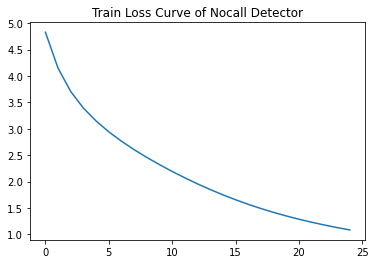

In [58]:
import matplotlib.pyplot as plt

train_losses = torch.tensor(train_losses, device = 'cpu')
plt.plot(np.arange(len(train_losses)), train_losses)
plt.title('Train Loss Curve of Nocall Detector')

C:\Users\ujubo\AppData\Local\Temp/ipykernel_26676/4126914523.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_losses = torch.tensor(val_losses, device = 'cpu')


Text(0.5, 1.0, 'Validation Accuracy Curve of Nocall Detector')

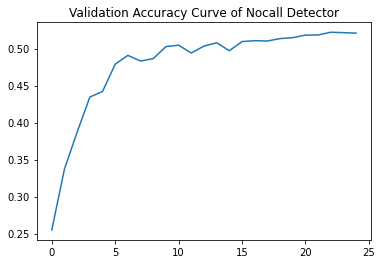

In [59]:
val_losses = torch.tensor(val_losses, device = 'cpu')
plt.plot(np.arange(len(val_losses)), val_losses)
plt.title('Validation Accuracy Curve of Nocall Detector')

C:\Users\ujubo\AppData\Local\Temp/ipykernel_26676/1290367574.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_scores = torch.tensor(log_scores, device = 'cpu')


Text(0.5, 1.0, 'Log-score Curve of Nocall Detector')

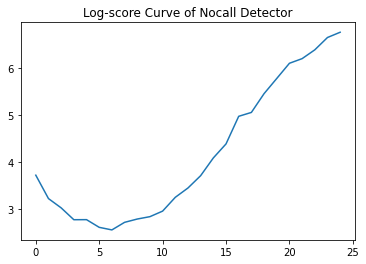

In [60]:
log_scores = torch.tensor(log_scores, device = 'cpu')
plt.plot(np.arange(len(log_scores)), log_scores)
plt.title('Log-score Curve of Nocall Detector')

C:\Users\ujubo\AppData\Local\Temp/ipykernel_26676/3035292173.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fbeta_scores = torch.tensor(fbeta_scores, device = 'cpu')


Text(0.5, 1.0, 'F-beta score Curve of Nocall Detector')

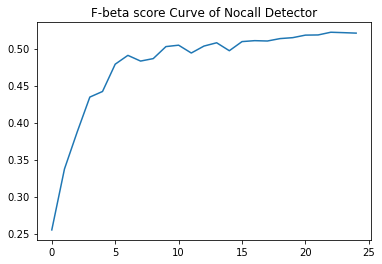

In [61]:
fbeta_scores = torch.tensor(fbeta_scores, device = 'cpu')
plt.plot(np.arange(len(fbeta_scores)), fbeta_scores)
plt.title('F-beta score Curve of Nocall Detector')

In [62]:
print('\nAccuracy: %.2f' % (100 * test_scores[0]))
print('Log Loss score:\t%.2f' % (test_scores[1]))
print('Fbeta-score (beta=1.0): \t%.2f' % (test_scores[2]))


Accuracy: 52.11
Log Loss score:	6.61
Fbeta-score (beta=1.0): 	0.52
